# <font color="red">Conditions Prediction with K Neighbors Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

import sys
# sys.path.append('../../') # Uncomment this line if running locally
sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
# weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

DateTime  Year  Month  Day  Hour DaySegments  \
0 2023-01-01 00:00:00  2023      1    1     0  Late Night   
1 2023-01-01 01:00:00  2023      1    1     1  Late Night   
2 2023-01-01 02:00:00  2023      1    1     2  Late Night   
3 2023-01-01 03:00:00  2023      1    1     3  Late Night   
4 2023-01-01 04:00:00  2023      1    1     4  Late Night   

   DaySegments_Afternoon  DaySegments_Early Morning  DaySegments_Evening  \
0                      0                          0                    0   
1                      0                          0                    0   
2                      0                          0                    0   
3                      0                          0                    0   
4                      0                          0                    0   

   DaySegments_Late Night  ...  WindDir  SeaLevelPressure  CloudCover  \
0                       1  ...     0.49           1018.68        0.03   
1                       1  ...     0.54           1018.03        0.11   
2                       1  ...    30.51           1017.56        0.03   
3                       1  ...    49.23           1018.05        0.00   
4                       1  ...    49.90           1018.00       86.17   

   UVIndex  SevereRisk  Visibility  SolarRadiation SolarEnergy  \
0      0.0        10.0        2.76             0.0         0.0   
1      0.0        10.0        1.75             0.0         0.0   
2      0.0        10.0        1.75             0.0         0.0   
3      0.0        10.0        2.28             0.0         0.0   
4      0.0        10.0        1.27             0.0         0.0   

         Conditions         Icon  
0             Clear  clear-night  
1             Clear  clear-night  
2             Clear  clear-night  
3             Clear  clear-night  
4  Partially cloudy          fog  

[5 rows x 36 columns]

In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

DateTime          Year         Month           Day  \
count                14616  14616.000000  14616.000000  14616.000000   
mean   2023-11-01 11:30:00   2023.400657      5.720854     15.735632   
min    2023-01-01 00:00:00   2023.000000      1.000000      1.000000   
25%    2023-06-02 05:45:00   2023.000000      3.000000      8.000000   
50%    2023-11-01 11:30:00   2023.000000      6.000000     16.000000   
75%    2024-04-01 17:15:00   2024.000000      8.000000     23.000000   
max    2024-08-31 23:00:00   2024.000000     12.000000     31.000000   
std                    NaN      0.490048      3.195073      8.803610   

               Hour  DaySegments_Afternoon  DaySegments_Early Morning  \
count  14616.000000           14616.000000               14616.000000   
mean      11.500000               0.131294                   0.060550   
min        0.000000               0.000000                   0.000000   
25%        5.750000               0.000000                   0.000000   
50%       11.500000               0.000000                   0.000000   
75%       17.250000               0.000000                   0.000000   
max       23.000000               1.000000                   1.000000   
std        6.922423               0.337734                   0.238511   

       DaySegments_Evening  DaySegments_Late Night  DaySegments_Midday  ...  \
count         14616.000000            14616.000000        14616.000000  ...   
mean              0.098043                0.249726            0.116585  ...   
min               0.000000                0.000000            0.000000  ...   
25%               0.000000                0.000000            0.000000  ...   
50%               0.000000                0.000000            0.000000  ...   
75%               0.000000                0.000000            0.000000  ...   
max               1.000000                1.000000            1.000000  ...   
std               0.297383                0.432869            0.320936  ...   

           Windgust     WindSpeed       WindDir  SeaLevelPressure  \
count  14616.000000  14616.000000  14616.000000      14616.000000   
mean      17.068560      8.090783    159.739178       1008.265012   
min        0.660000      0.000000      0.000000        982.420000   
25%        9.170000      2.870000     80.965000       1003.277500   
50%       14.645000      7.670000    163.790000       1007.970000   
75%       23.410000     11.750000    241.402500       1013.400000   
max       84.120000     71.970000    360.000000       1022.060000   
std       10.195911      6.250203    104.422027          6.010683   

         CloudCover       UVIndex    SevereRisk    Visibility  SolarRadiation  \
count  14616.000000  14616.000000  14616.000000  14616.000000    14616.000000   
mean      53.579923      2.263555     16.504787      4.368134      227.640683   
min        0.000000      0.000000      3.000000      0.000000        0.000000   
25%       26.670000      0.000000     10.000000      3.990000        0.000000   
50%       51.540000      0.000000     10.000000      4.650000       10.665000   
75%       87.790000      4.740000     12.580000      4.650000      459.745000   
max      100.000000     10.000000     97.740000     24.100000     1026.650000   
std       35.166637      3.083074     15.031827      1.376994      307.219387   

        SolarEnergy  
count  14616.000000  
mean       0.819217  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        1.660000  
max        3.700000  
std        1.106444  

[8 rows x 32 columns]

# Data Split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data, weather_data['Conditions']):
    weather_data_train = weather_data.iloc[train_idx]
    weather_data_test = weather_data.iloc[test_idx]

In [6]:
# Show the count of each unique class in Conditions
class_counts = weather_data['Conditions'].value_counts().reset_index()
class_counts.columns = ['Conditions', 'Count']

print("Distribution of data based on Conditions:")
print(class_counts)

Distribution of data based on Conditions:
               Conditions  Count
0        Partially cloudy   7785
1                   Clear   3316
2  Rain, Partially cloudy   2118
3          Rain, Overcast    746
4                Overcast    629
5                    Rain     22


In [7]:
print("Distribution of Conditions in Training Set:")
print(weather_data_train['Conditions'].value_counts())

print("\nDistribution of Conditions in Test Set:")
print(weather_data_test['Conditions'].value_counts())

Distribution of Conditions in Training Set:
Conditions
Partially cloudy          6227
Clear                     2653
Rain, Partially cloudy    1694
Rain, Overcast             597
Overcast                   503
Rain                        18
Name: count, dtype: int64

Distribution of Conditions in Test Set:
Conditions
Partially cloudy          1558
Clear                      663
Rain, Partially cloudy     424
Rain, Overcast             149
Overcast                   126
Rain                         4
Name: count, dtype: int64


# Some Reused Parameters

In [8]:
grid_param = {
    # Core KNN parameters
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 25],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    
    # Minkowski-specific parameter
    'p': [1, 2, 3],  # Only used when metric='minkowski'
    
    # Leaf size for tree algorithms
    'leaf_size': [10, 20, 30, 40, 50]
}

In [9]:
number_of_model_for_randomized_grid = 400
model_name_for_saving = "KNN"
target_name_for_saving = "Conditions"
number_of_model_for_bagging = 100

# All Features

In [10]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Conditions']

In [11]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Conditions']

In [12]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [13]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## MinMax Scaler

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [15]:
X_train

array([[0.81818182, 0.46666667, 0.69565217, ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.16666667, 0.86956522, ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.3       , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.83333333, 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.53333333, 0.34782609, ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.8       , 0.65217391, ..., 0.8155    , 0.542     ,
        0.07388643]])

In [16]:
X_test

array([[0.18181818, 0.4       , 0.52173913, ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 0.06666667, 1.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.56666667, 0.73913043, ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.76666667, 0.82608696, ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.43333333, 0.86956522, ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.66666667, 0.26086957, ..., 0.4901    , 0.        ,
        0.99324467]])

### Default Parameters

In [17]:
training_model = KNeighborsClassifier(n_neighbors=25)
training_model

KNeighborsClassifier(n_neighbors=25)

In [18]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.8 ms, sys: 1.83 ms, total: 14.6 ms
Wall time: 13.6 ms


KNeighborsClassifier(n_neighbors=25)

In [19]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [20]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [21]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [22]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8683
Precision: 0.8729
Recall:    0.8683
F1-Score:  0.8412


In [23]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.91      0.89      0.90       663
              Overcast       1.00      0.01      0.02       126
      Partially cloudy       0.88      0.96      0.92      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.81      0.30      0.43       149
Rain, Partially cloudy       0.80      0.96      0.87       424

              accuracy                           0.87      2924
             macro avg       0.73      0.52      0.52      2924
          weighted avg       0.87      0.87      0.84      2924



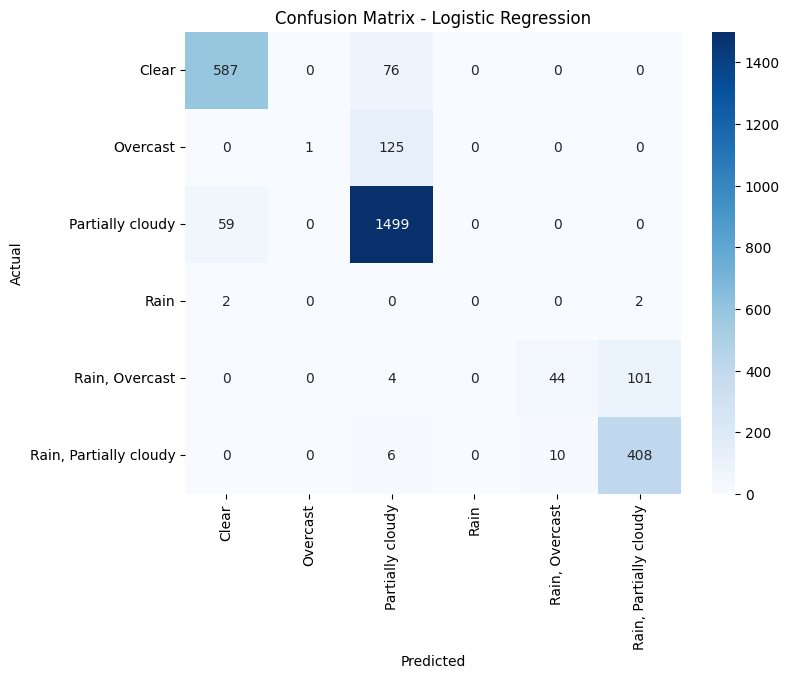

In [24]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [26]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9903
Overcast : 0.9242
Partially cloudy : 0.9663
Rain     : 0.7471
Rain, Overcast : 0.9690
Rain, Partially cloudy : 0.9896
Micro-avg : 0.9867


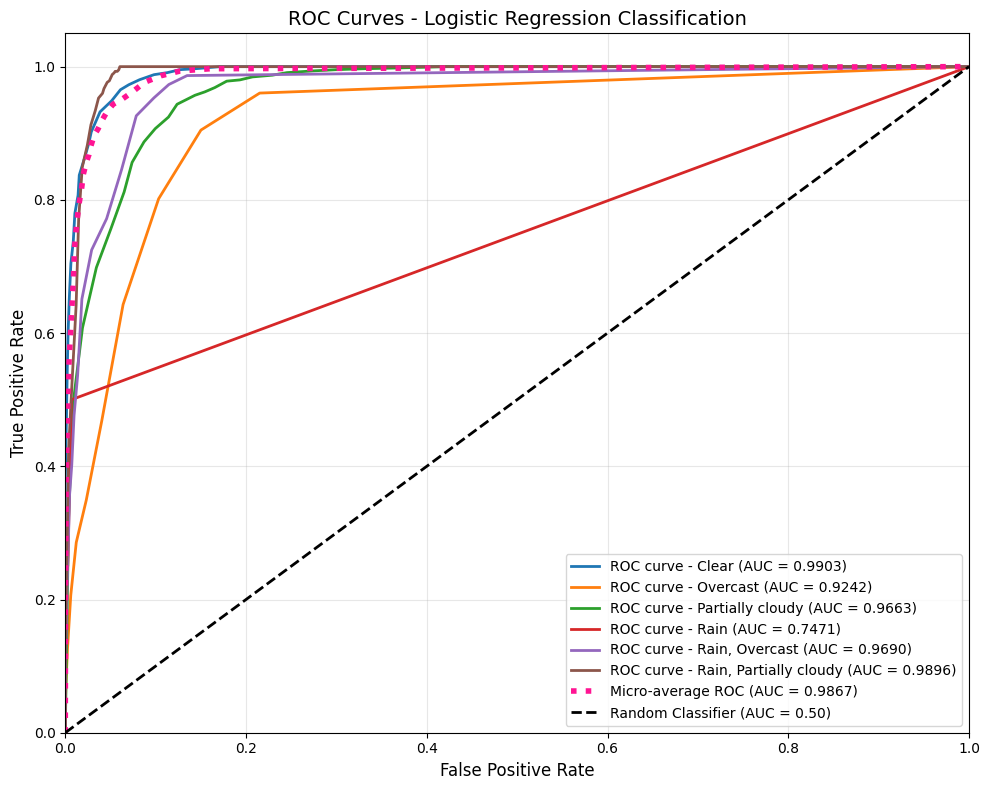

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9731
One-vs-One (Weighted)  : 0.9349
Micro-average          : 0.9867


In [30]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.868331, F1: 0.841179, AUC (micro-avg): 0.986679
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [31]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [32]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 15.6 s, sys: 6.37 s, total: 21.9 s
Wall time: 1h 23min 46s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.8933431538923025


In [34]:
y_pred_grid = best_grid_model.predict(X_test)

In [35]:
y_pred_grid

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Overcast', 'Partially cloudy', 'Partially cloudy'], dtype=object)

In [36]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [37]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [38]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9107
Precision: 0.9036
Recall:    0.9107
F1-Score:  0.9041


In [39]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.94      0.94      0.94       663
              Overcast       0.67      0.34      0.45       126
      Partially cloudy       0.92      0.96      0.94      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.83      0.68      0.75       149
Rain, Partially cloudy       0.89      0.94      0.92       424

              accuracy                           0.91      2924
             macro avg       0.71      0.64      0.67      2924
          weighted avg       0.90      0.91      0.90      2924



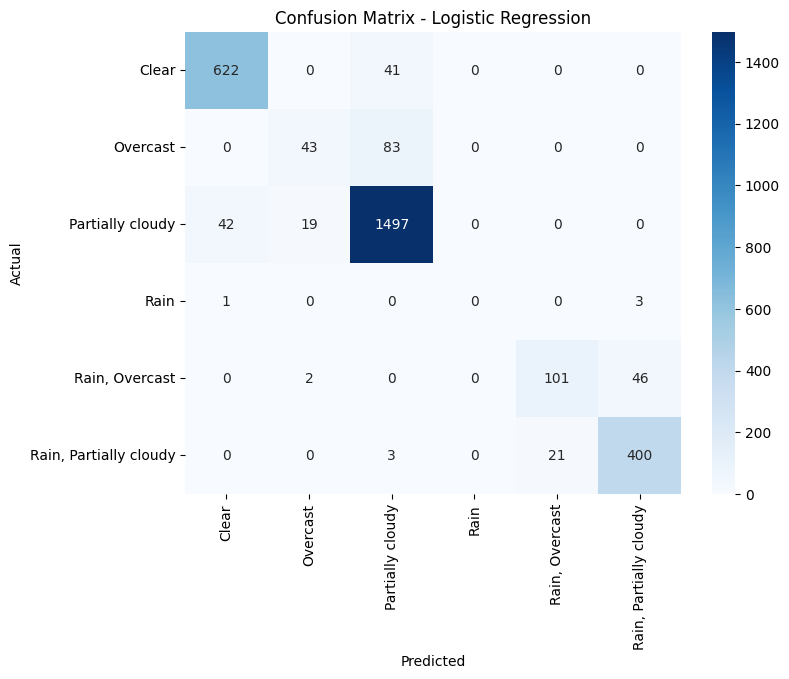

In [40]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [42]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [43]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9850
Overcast : 0.8204
Partially cloudy : 0.9663
Rain     : 0.4993
Rain, Overcast : 0.9388
Rain, Partially cloudy : 0.9923
Micro-avg : 0.9784


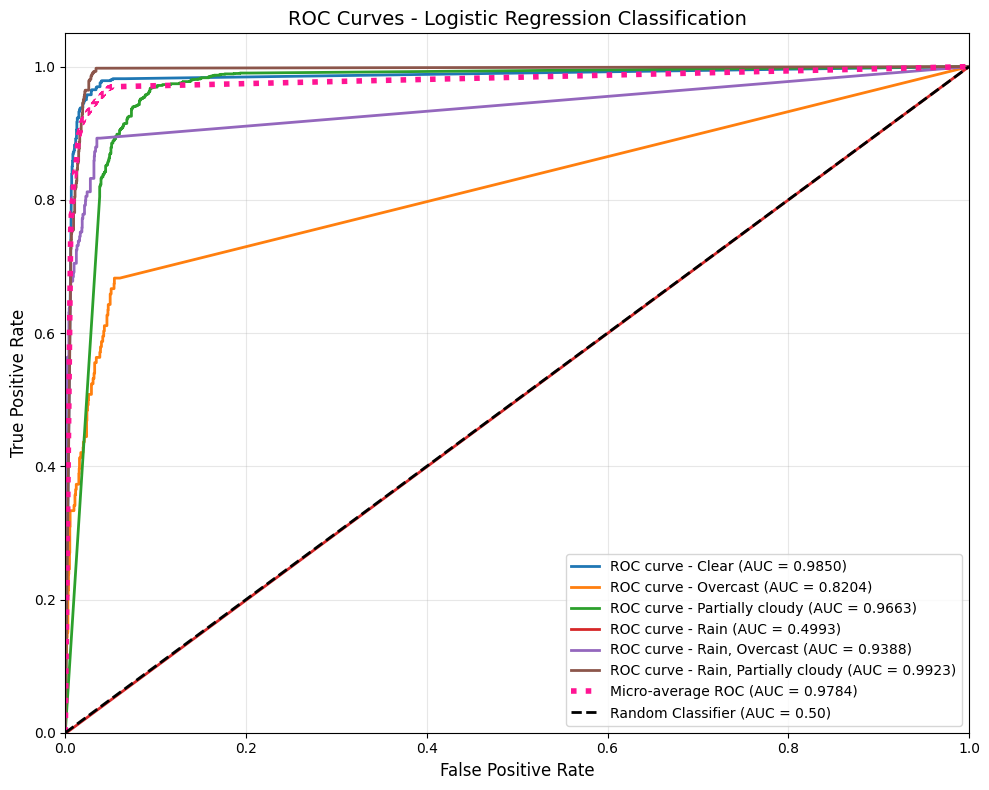

In [44]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9660
One-vs-One (Weighted)  : 0.8957
Micro-average          : 0.9784


In [46]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.910739, F1: 0.904122, AUC (micro-avg): 0.978410
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [47]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [48]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [49]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s


CPU times: user 183 ms, sys: 544 ms, total: 727 ms
Wall time: 1.44 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.5s finished


In [51]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [52]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9360
Precision: 0.9390
Recall:    0.9360
F1-Score:  0.9230


In [53]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.96      0.97       663
              Overcast       1.00      0.18      0.31       126
      Partially cloudy       0.92      0.99      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.98      0.70      0.82       149
Rain, Partially cloudy       0.90      1.00      0.95       424

              accuracy                           0.94      2924
             macro avg       0.80      0.64      0.67      2924
          weighted avg       0.94      0.94      0.92      2924



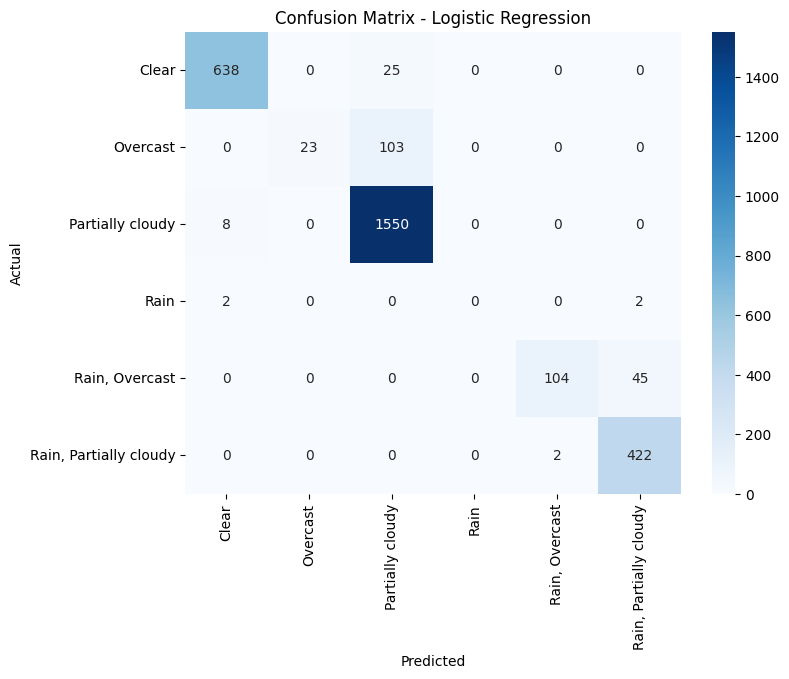

In [54]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.6s remaining:    7.6s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.9s finished


In [56]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [57]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9985
Overcast : 0.9762
Partially cloudy : 0.9905
Rain     : 0.8640
Rain, Overcast : 0.9924
Rain, Partially cloudy : 0.9969
Micro-avg : 0.9939


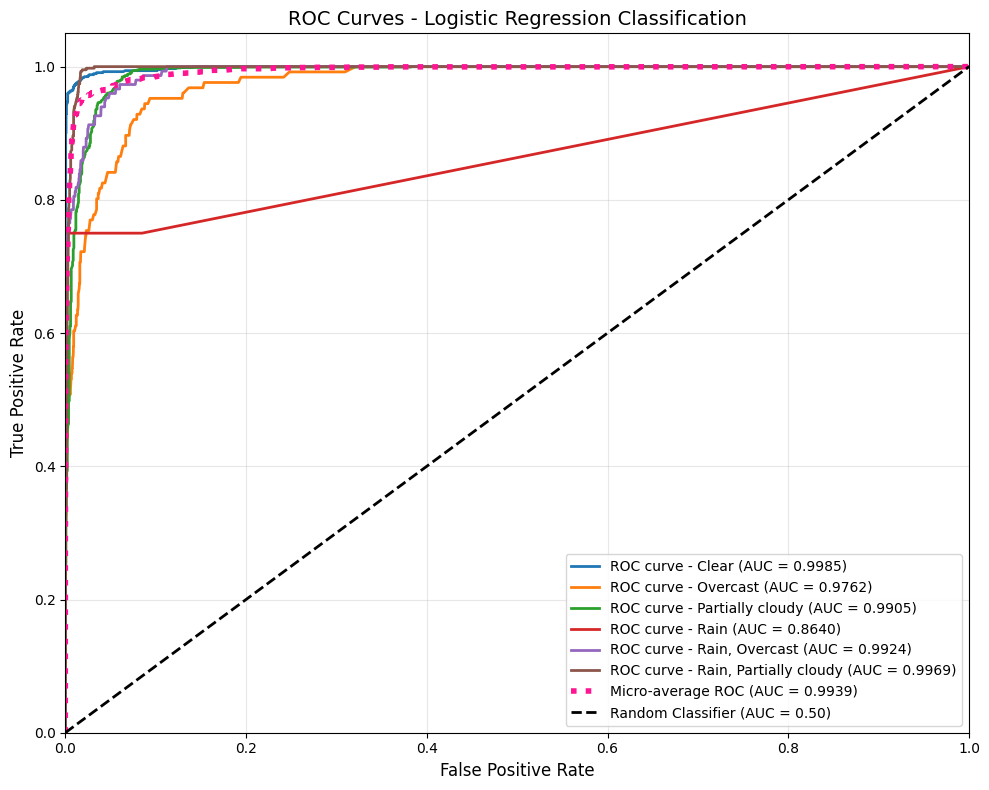

In [58]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [59]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9925
One-vs-One (Weighted)  : 0.9753
Micro-average          : 0.9939


In [60]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.936047, F1: 0.923048, AUC (micro-avg): 0.993900
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [62]:
X_train

array([[ 1.34459066, -0.08798128,  0.64443839, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082, -1.10860676,  1.22392493, ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -0.65499543, -1.67350776, ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082,  1.15944987, -1.67350776, ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 ,  0.13882439, -0.51453468, ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  1.04604704,  0.49956676, ...,  0.79539807,
         1.00886284, -0.43437432]])

In [63]:
X_test

array([[-0.8453494 , -0.31478694,  0.06495186, ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208, -1.44881525,  1.65853984, ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.25222722,  0.78931003, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  0.9326442 ,  1.0790533 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208, -0.20138411,  1.22392493, ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082,  0.59243571, -0.80427795, ..., -0.12954086,
        -0.74169989,  5.41145777]])

### Default Parameters

In [64]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [65]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 12 ms


KNeighborsClassifier()

In [66]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [67]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [68]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [69]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8663
Precision: 0.8539
Recall:    0.8663
F1-Score:  0.8516


In [70]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.89      0.89      0.89       663
              Overcast       0.60      0.12      0.20       126
      Partially cloudy       0.88      0.95      0.91      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.72      0.52      0.61       149
Rain, Partially cloudy       0.84      0.89      0.87       424

              accuracy                           0.87      2924
             macro avg       0.65      0.56      0.58      2924
          weighted avg       0.85      0.87      0.85      2924



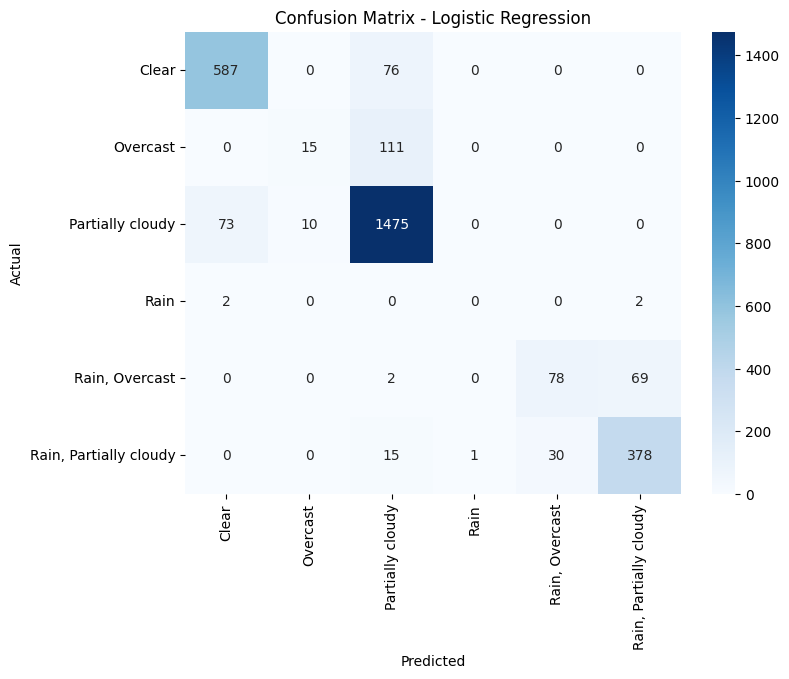

In [71]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [73]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [74]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9838
Overcast : 0.8272
Partially cloudy : 0.9567
Rain     : 0.6234
Rain, Overcast : 0.9019
Rain, Partially cloudy : 0.9854
Micro-avg : 0.9751


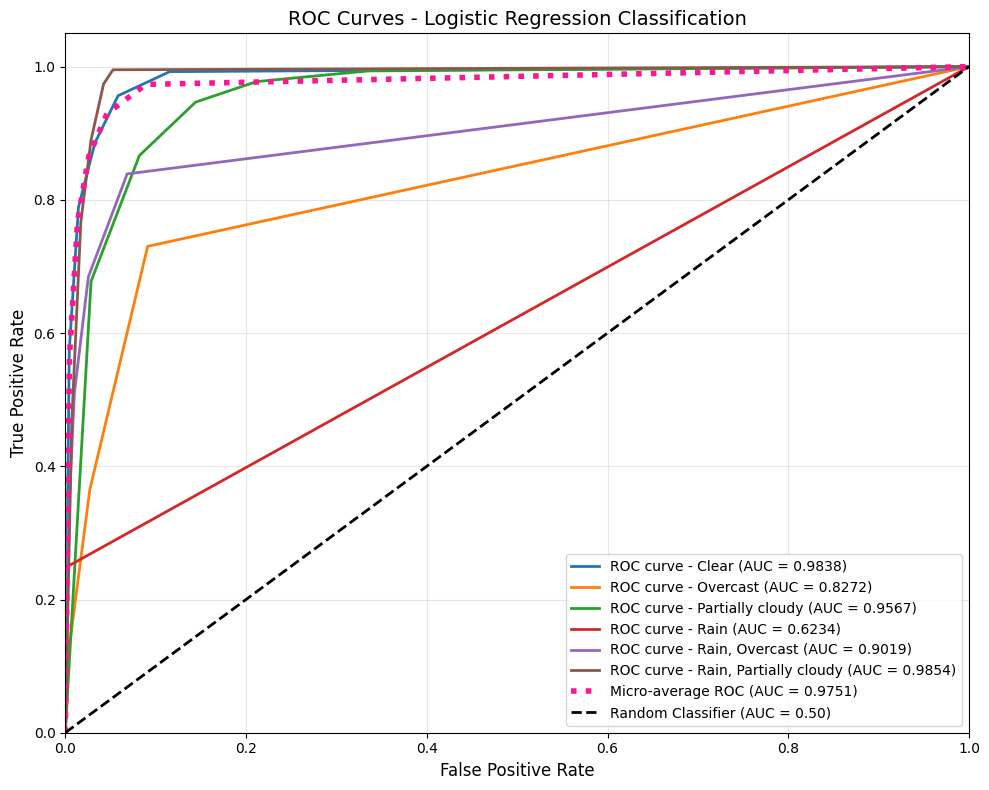

In [75]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9582
One-vs-One (Weighted)  : 0.8992
Micro-average          : 0.9751


In [77]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.866279, F1: 0.851559, AUC (micro-avg): 0.975107
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [78]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [79]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 19.8 s, sys: 9.44 s, total: 29.3 s
Wall time: 1h 45min 28s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.8621572464824977


In [81]:
y_pred_grid = best_grid_model.predict(X_test)

In [82]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [83]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8748
Precision: 0.8669
Recall:    0.8748
F1-Score:  0.8655


In [84]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.88      0.90      0.89       663
              Overcast       0.67      0.25      0.36       126
      Partially cloudy       0.89      0.94      0.91      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.79      0.62      0.69       149
Rain, Partially cloudy       0.87      0.89      0.88       424

              accuracy                           0.87      2924
             macro avg       0.68      0.60      0.62      2924
          weighted avg       0.87      0.87      0.87      2924



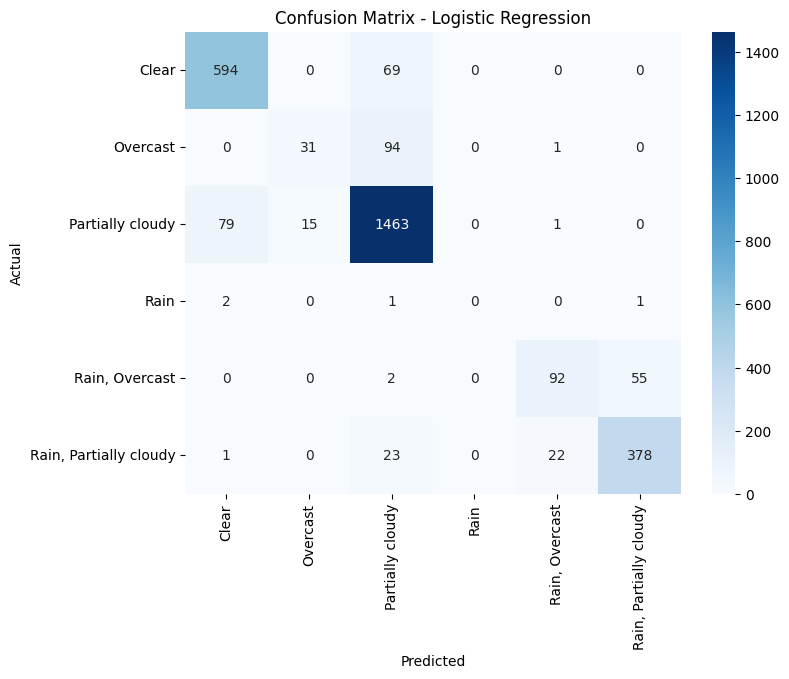

In [85]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [86]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [87]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [88]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9813
Overcast : 0.8451
Partially cloudy : 0.9576
Rain     : 0.4985
Rain, Overcast : 0.9407
Rain, Partially cloudy : 0.9864
Micro-avg : 0.9773


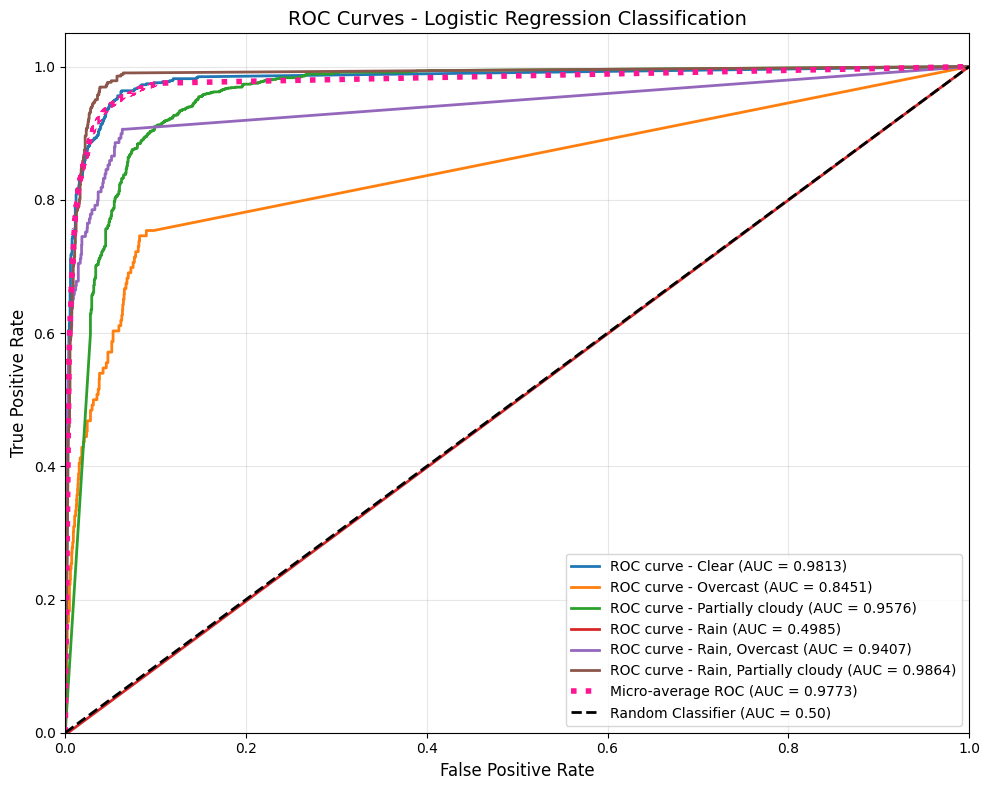

In [89]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9608
One-vs-One (Weighted)  : 0.8929
Micro-average          : 0.9773


In [91]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.874829, F1: 0.865547, AUC (micro-avg): 0.977319
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [92]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [93]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [94]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s


CPU times: user 273 ms, sys: 397 ms, total: 670 ms
Wall time: 1.24 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.5s finished


In [96]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [97]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9189
Precision: 0.9224
Recall:    0.9189
F1-Score:  0.9038


In [98]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.95      0.96       663
              Overcast       1.00      0.16      0.27       126
      Partially cloudy       0.92      0.99      0.95      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.93      0.56      0.70       149
Rain, Partially cloudy       0.86      0.98      0.92       424

              accuracy                           0.92      2924
             macro avg       0.78      0.61      0.63      2924
          weighted avg       0.92      0.92      0.90      2924



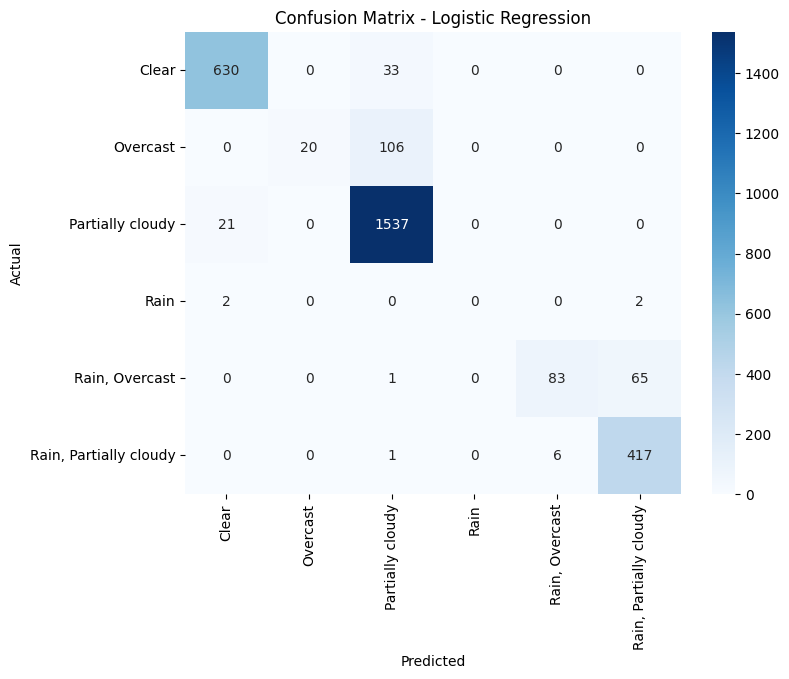

In [99]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [100]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.2s remaining:    7.2s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.6s finished


In [101]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [102]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9976
Overcast : 0.9600
Partially cloudy : 0.9859
Rain     : 0.8638
Rain, Overcast : 0.9866
Rain, Partially cloudy : 0.9940
Micro-avg : 0.9917


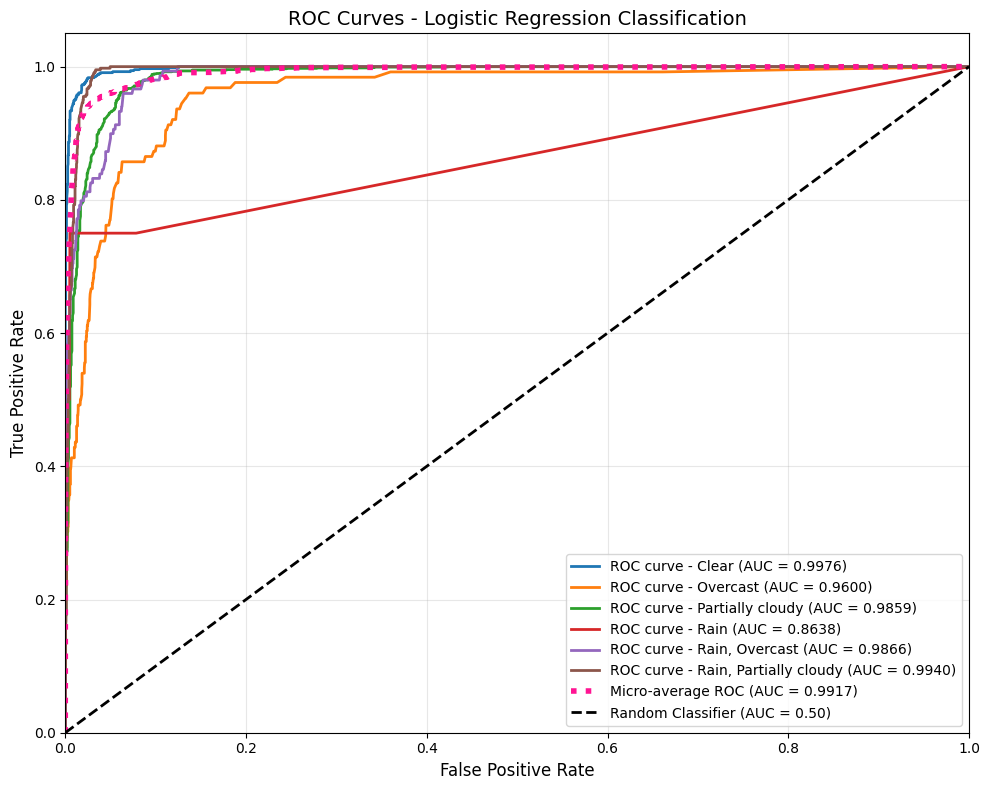

In [103]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9885
One-vs-One (Weighted)  : 0.9688
Micro-average          : 0.9917


In [105]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.918947, F1: 0.903790, AUC (micro-avg): 0.991704
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [106]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [107]:
X_train

array([[ 1.00000000e+00, -6.66666667e-02,  3.33333333e-01, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01, -6.66666667e-01,  6.66666667e-01, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -4.00000000e-01, -1.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01,  6.66666667e-01, -1.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01,  6.66666667e-02, -3.33333333e-01, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  6.00000000e-01,  2.50000000e-01, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]])

In [108]:
X_test

array([[-0.4       , -0.2       ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       , -0.86666667,  0.91666667, ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.13333333,  0.41666667, ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.53333333,  0.58333333, ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       , -0.13333333,  0.66666667, ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       ,  0.33333333, -0.5       , ..., -0.04159162,
         0.        , 33.75968992]])

### Default Parameters

In [109]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [110]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 11.7 ms


KNeighborsClassifier()

In [111]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [112]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [113]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [114]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8358
Precision: 0.8152
Recall:    0.8358
F1-Score:  0.8183


In [115]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.86      0.84      0.85       663
              Overcast       0.44      0.10      0.16       126
      Partially cloudy       0.87      0.93      0.90      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.51      0.32      0.39       149
Rain, Partially cloudy       0.78      0.89      0.83       424

              accuracy                           0.84      2924
             macro avg       0.58      0.51      0.52      2924
          weighted avg       0.82      0.84      0.82      2924



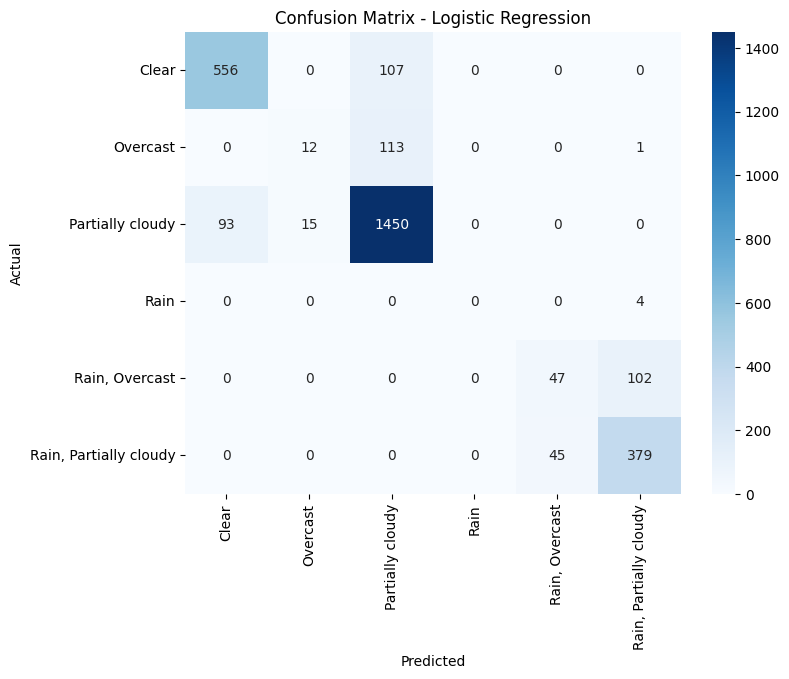

In [116]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [117]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [118]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [119]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9743
Overcast : 0.7754
Partially cloudy : 0.9423
Rain     : 0.6235
Rain, Overcast : 0.8763
Rain, Partially cloudy : 0.9711
Micro-avg : 0.9662


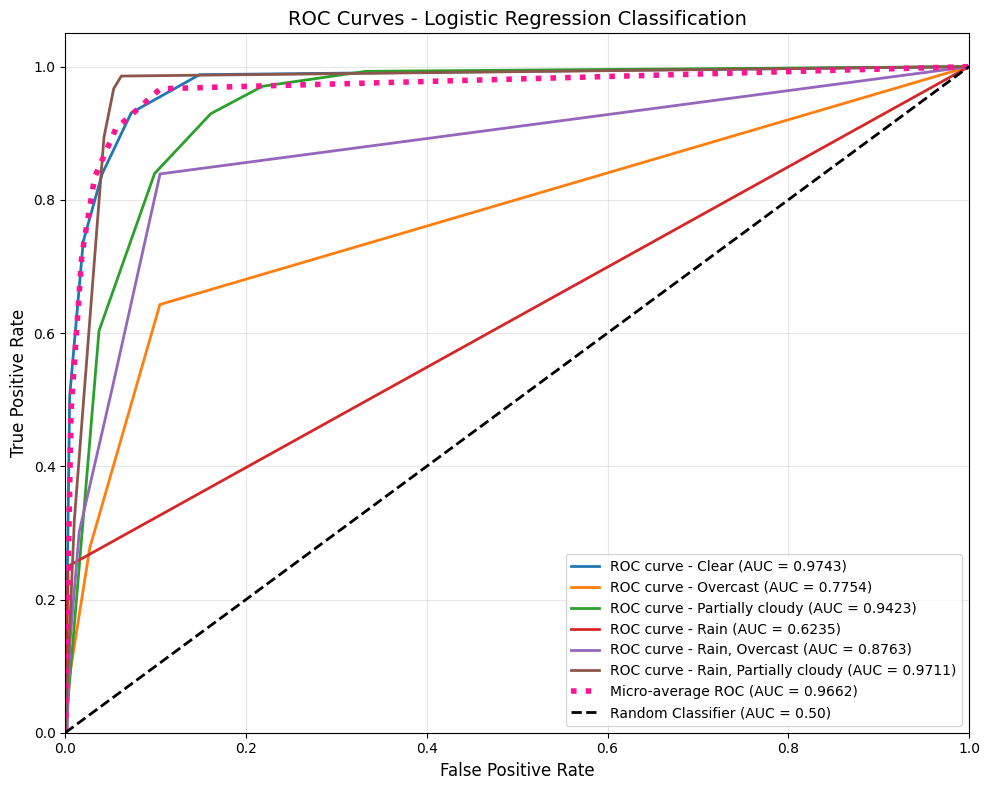

In [120]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [121]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9427
One-vs-One (Weighted)  : 0.8753
Micro-average          : 0.9662


In [122]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.835841, F1: 0.818291, AUC (micro-avg): 0.966204
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [123]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [124]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 13.6 s, sys: 5.98 s, total: 19.6 s
Wall time: 1h 17min 29s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [125]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'metric': 'manhattan', 'leaf_size': 20, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.846781483096861


In [126]:
y_pred_grid = best_grid_model.predict(X_test)

In [127]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [128]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8505
Precision: 0.8252
Recall:    0.8505
F1-Score:  0.8304


In [129]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.88      0.88      0.88       663
              Overcast       0.35      0.05      0.08       126
      Partially cloudy       0.88      0.94      0.91      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.55      0.34      0.42       149
Rain, Partially cloudy       0.79      0.91      0.84       424

              accuracy                           0.85      2924
             macro avg       0.57      0.52      0.52      2924
          weighted avg       0.83      0.85      0.83      2924



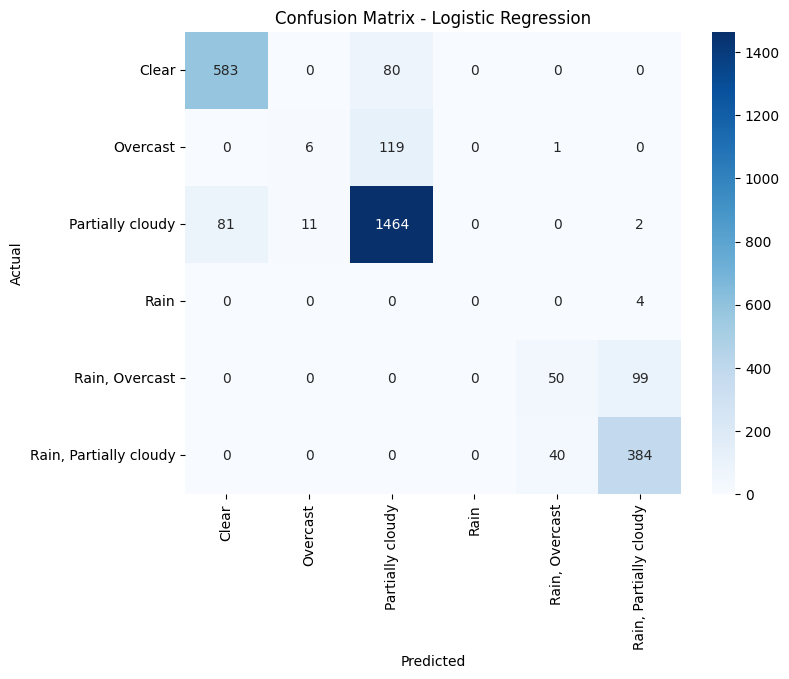

In [130]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [131]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [132]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [133]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9822
Overcast : 0.8294
Partially cloudy : 0.9523
Rain     : 0.7469
Rain, Overcast : 0.9373
Rain, Partially cloudy : 0.9834
Micro-avg : 0.9769


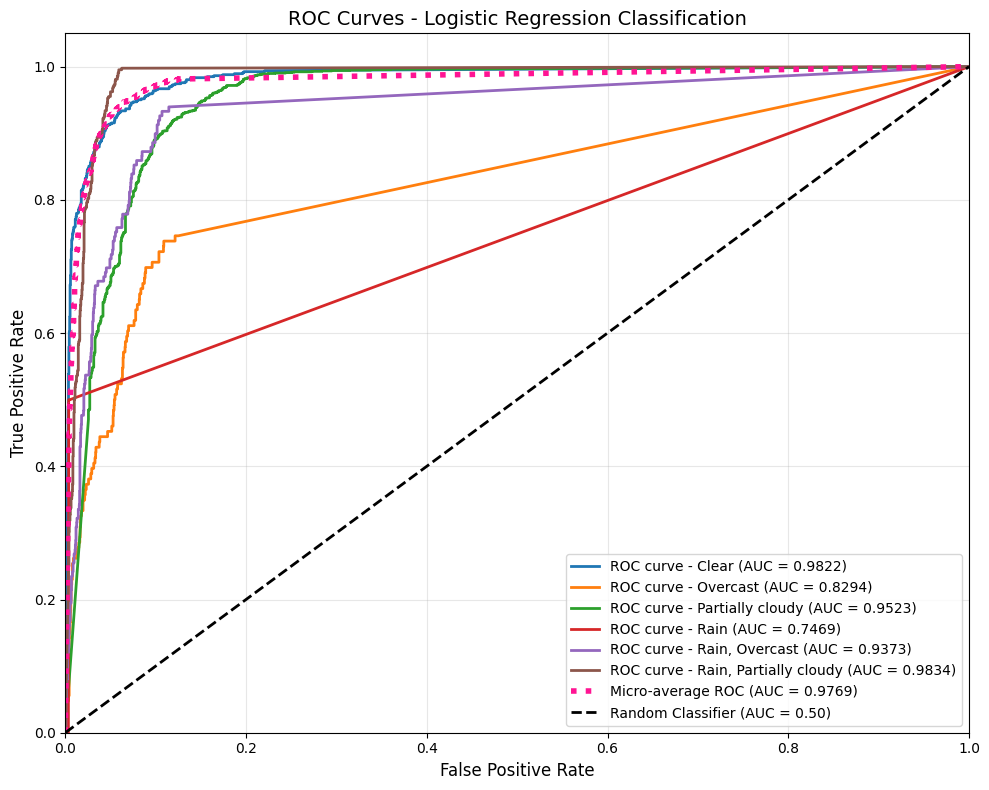

In [134]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [135]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9573
One-vs-One (Weighted)  : 0.9088
Micro-average          : 0.9769


In [136]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.850547, F1: 0.830422, AUC (micro-avg): 0.976872
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [137]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [138]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [139]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s


CPU times: user 184 ms, sys: 502 ms, total: 686 ms
Wall time: 1.23 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.7s remaining:    7.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.1s finished


In [141]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [142]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8923
Precision: 0.8948
Recall:    0.8923
F1-Score:  0.8674


In [143]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.93      0.94       663
              Overcast       1.00      0.02      0.05       126
      Partially cloudy       0.90      0.98      0.94      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.76      0.35      0.48       149
Rain, Partially cloudy       0.80      0.96      0.88       424

              accuracy                           0.89      2924
             macro avg       0.74      0.54      0.55      2924
          weighted avg       0.89      0.89      0.87      2924



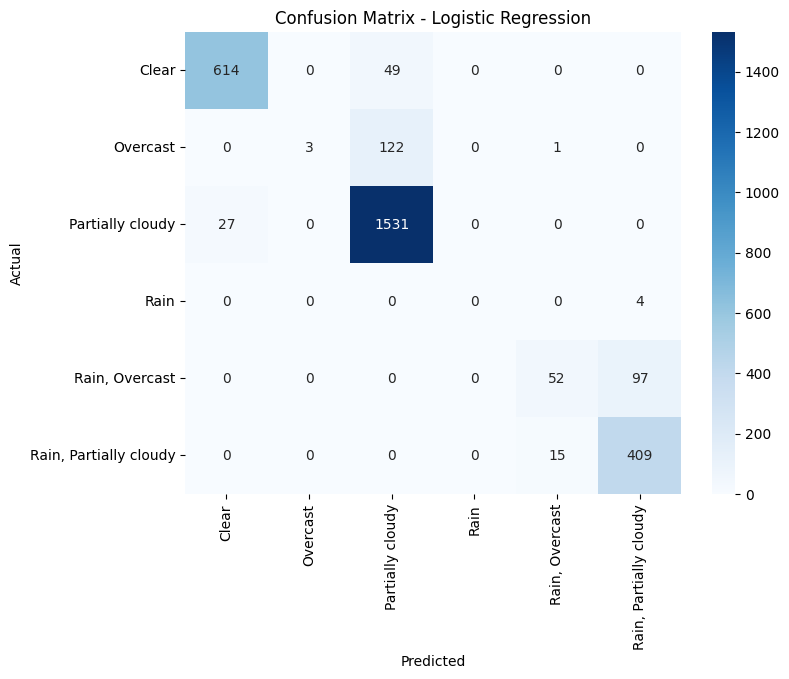

In [144]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [145]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.1s remaining:    7.1s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.5s finished


In [146]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [147]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9961
Overcast : 0.9496
Partially cloudy : 0.9805
Rain     : 0.8570
Rain, Overcast : 0.9746
Rain, Partially cloudy : 0.9880
Micro-avg : 0.9896


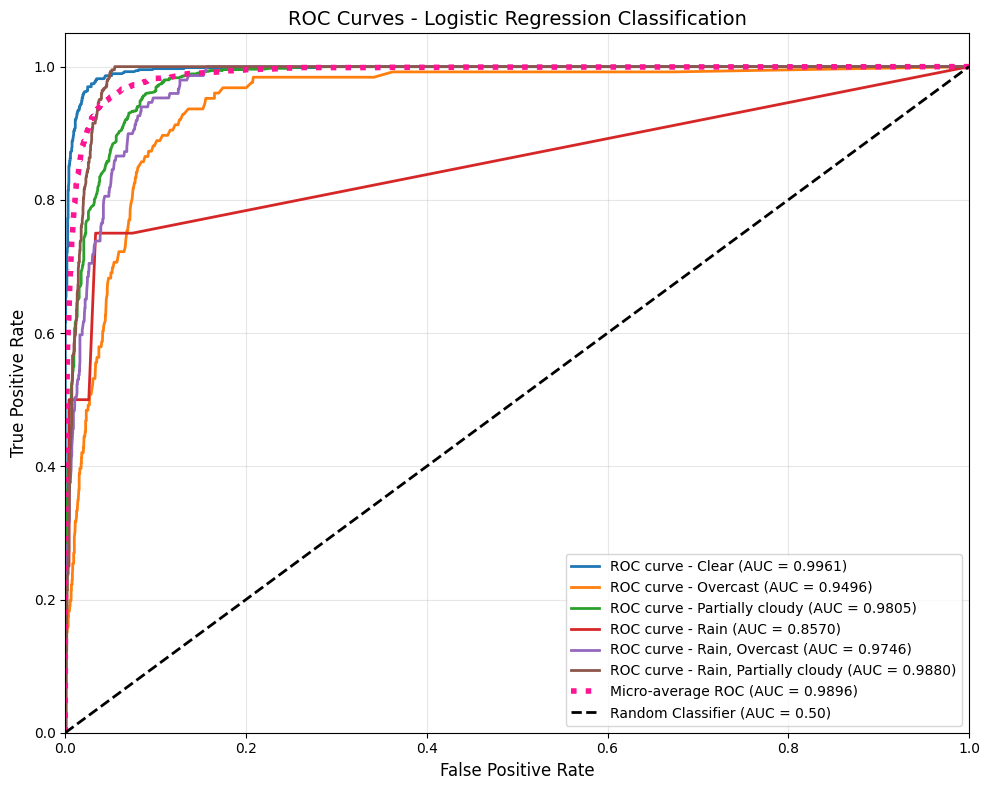

In [148]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [149]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9833
One-vs-One (Weighted)  : 0.9538
Micro-average          : 0.9896


In [150]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.892271, F1: 0.867422, AUC (micro-avg): 0.989586
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [151]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [152]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [153]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [154]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [155]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


### MinMax Scaler

In [156]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [157]:
X_train

array([[0.81818182, 0.69565217, 1.        , ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.        , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.        , 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.34782609, 0.        , ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.65217391, 1.        , ..., 0.8155    , 0.542     ,
        0.07388643]])

In [158]:
X_test

array([[0.18181818, 0.52173913, 0.        , ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 1.        , 0.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.73913043, 1.        , ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.82608696, 0.        , ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.86956522, 0.        , ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.26086957, 0.        , ..., 0.4901    , 0.        ,
        0.99324467]])

#### Default Parameters

In [159]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [160]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.5 ms, sys: 398 µs, total: 12.9 ms
Wall time: 11.8 ms


KNeighborsClassifier()

In [161]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [162]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [163]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [164]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9367
Precision: 0.9352
Recall:    0.9367
F1-Score:  0.9288


In [165]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.97      0.97       663
              Overcast       0.85      0.32      0.46       126
      Partially cloudy       0.93      0.99      0.96      1558
                  Rain       1.00      0.25      0.40         4
        Rain, Overcast       0.93      0.69      0.79       149
Rain, Partially cloudy       0.90      0.98      0.94       424

              accuracy                           0.94      2924
             macro avg       0.93      0.70      0.75      2924
          weighted avg       0.94      0.94      0.93      2924



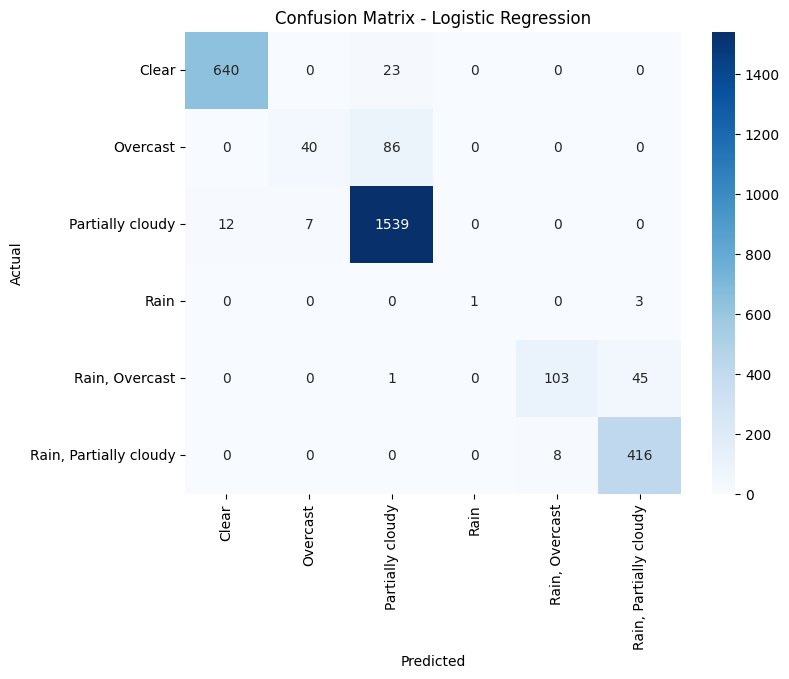

In [166]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [167]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [168]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [169]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9952
Overcast : 0.8992
Partially cloudy : 0.9841
Rain     : 0.7495
Rain, Overcast : 0.9495
Rain, Partially cloudy : 0.9937
Micro-avg : 0.9889


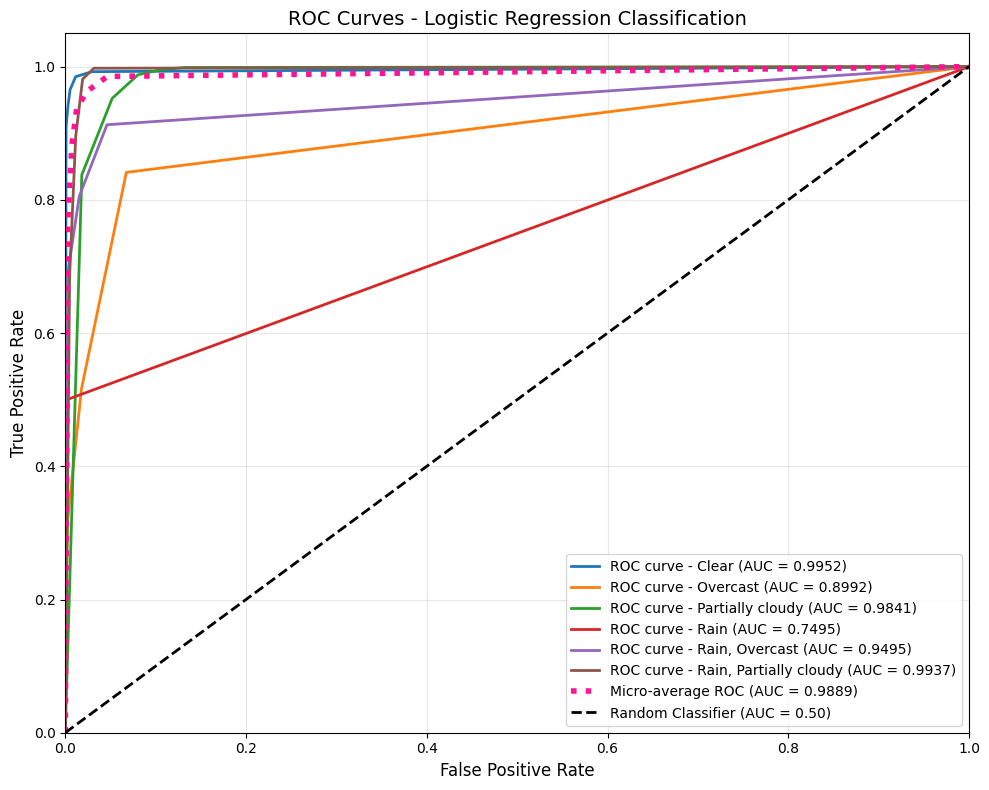

In [170]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [171]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9823
One-vs-One (Weighted)  : 0.9432
Micro-average          : 0.9889


In [172]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.868331 → 0.936731
   F1-Score: 0.841179 → 0.928818
   AUC (micro-avg): 0.986679 → 0.988869
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [173]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [174]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 11.6 s, sys: 4.83 s, total: 16.4 s
Wall time: 1h 6min 52s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.9300503537470435


In [176]:
y_pred_grid = best_grid_model.predict(X_test)

In [177]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [178]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9408
Precision: 0.9385
Recall:    0.9408
F1-Score:  0.9364


In [179]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.97      0.97      0.97       663
              Overcast       0.80      0.47      0.59       126
      Partially cloudy       0.95      0.98      0.96      1558
                  Rain       1.00      0.25      0.40         4
        Rain, Overcast       0.92      0.71      0.80       149
Rain, Partially cloudy       0.90      0.98      0.94       424

              accuracy                           0.94      2924
             macro avg       0.92      0.73      0.78      2924
          weighted avg       0.94      0.94      0.94      2924



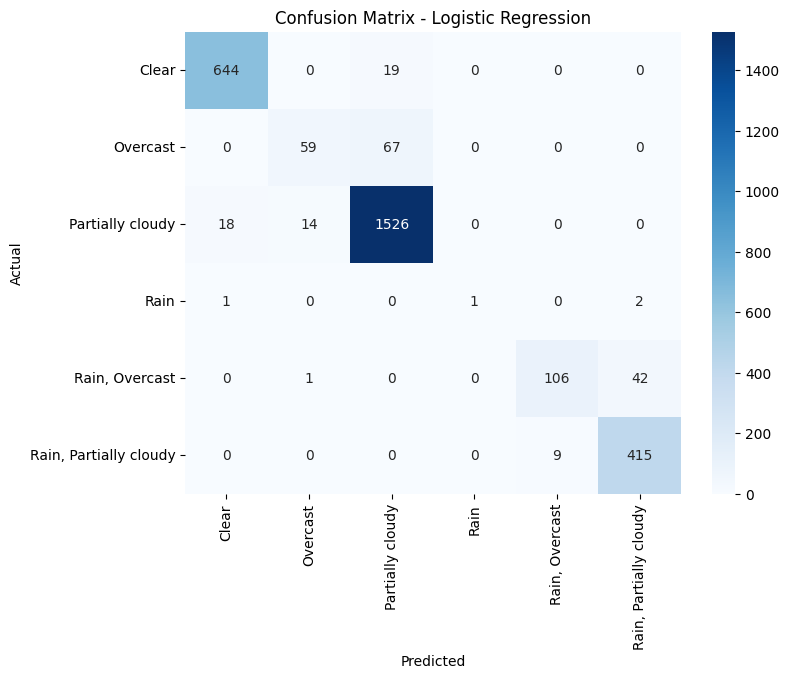

In [180]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [181]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [182]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [183]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9923
Overcast : 0.8748
Partially cloudy : 0.9809
Rain     : 0.7497
Rain, Overcast : 0.9421
Rain, Partially cloudy : 0.9930
Micro-avg : 0.9856


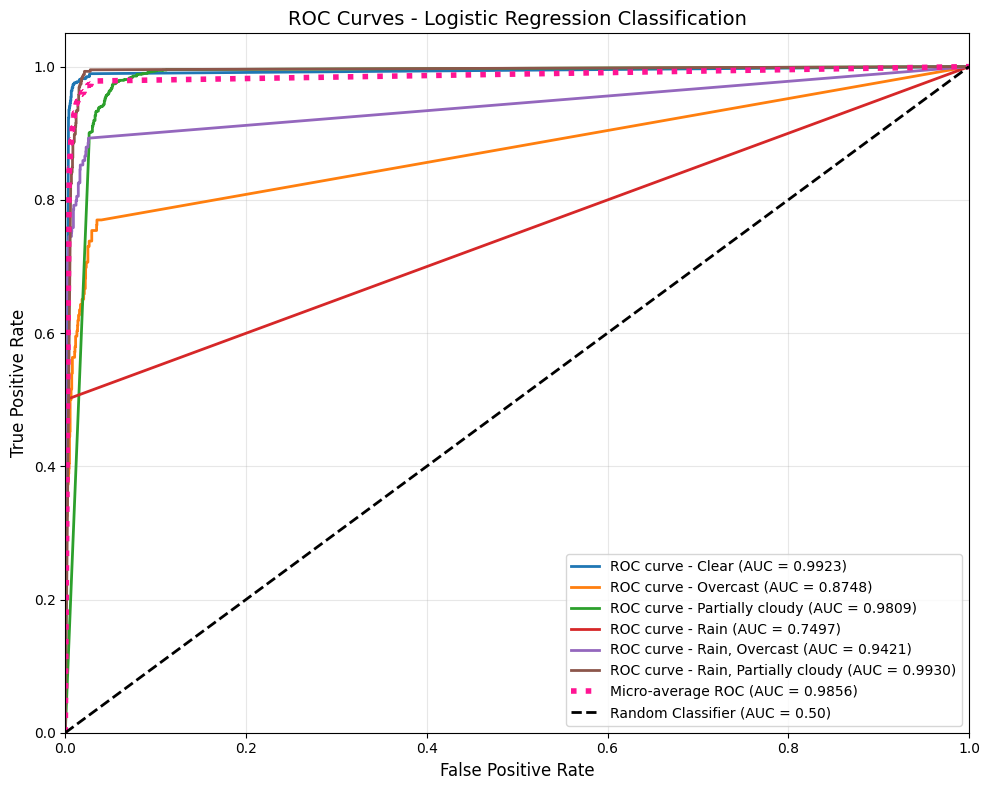

In [184]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [185]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9784
One-vs-One (Weighted)  : 0.9353
Micro-average          : 0.9856


In [186]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.910739 → 0.940834
   F1-Score: 0.904122 → 0.936439
   AUC (micro-avg): 0.978410 → 0.985629
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [187]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [188]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [189]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s


CPU times: user 201 ms, sys: 419 ms, total: 620 ms
Wall time: 1.11 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.2s finished


In [191]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [192]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9439
Precision: 0.9459
Recall:    0.9439
F1-Score:  0.9352


In [193]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.96      0.97       663
              Overcast       1.00      0.30      0.46       126
      Partially cloudy       0.93      0.99      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.99      0.76      0.86       149
Rain, Partially cloudy       0.91      1.00      0.95       424

              accuracy                           0.94      2924
             macro avg       0.80      0.67      0.70      2924
          weighted avg       0.95      0.94      0.94      2924



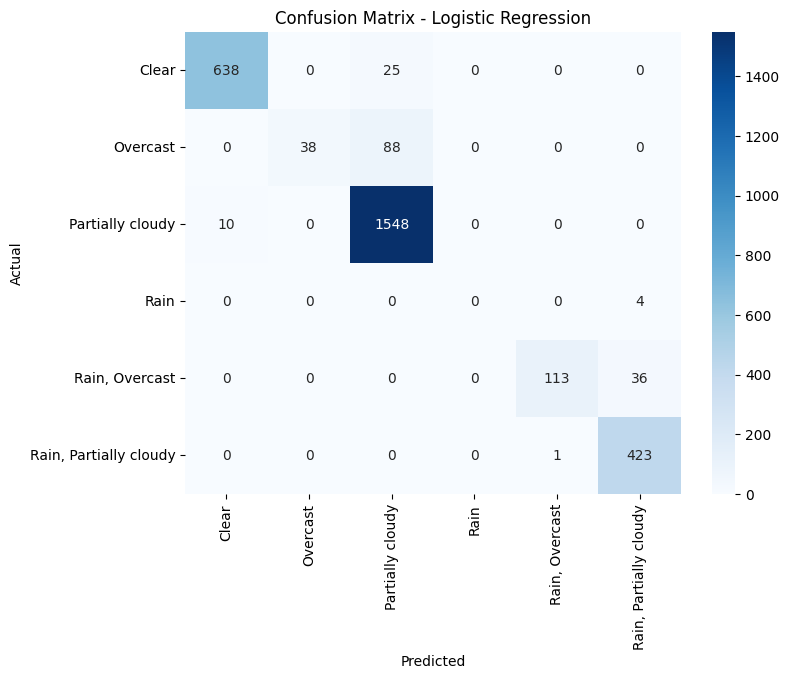

In [194]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [195]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.8s remaining:    6.8s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.2s finished


In [196]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [197]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9968
Overcast : 0.9828
Partially cloudy : 0.9916
Rain     : 0.8625
Rain, Overcast : 0.9920
Rain, Partially cloudy : 0.9975
Micro-avg : 0.9937


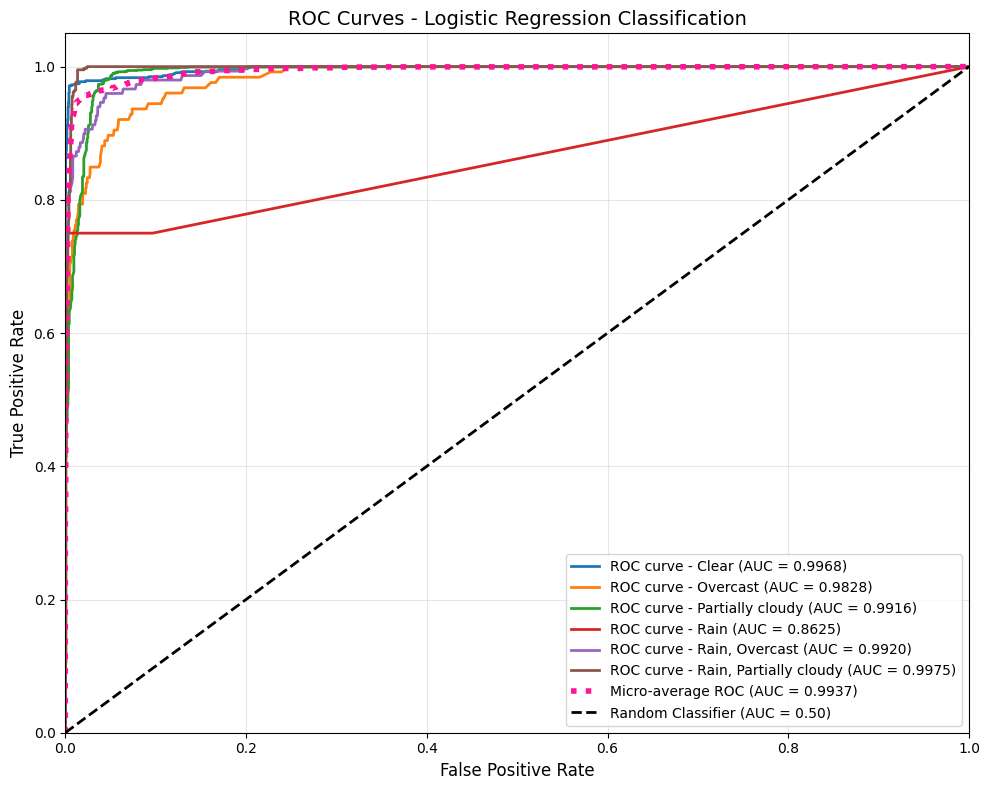

In [198]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [199]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9931
One-vs-One (Weighted)  : 0.9767
Micro-average          : 0.9937


In [200]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.936047 → 0.943912
   F1-Score: 0.923048 → 0.935225
   AUC (micro-avg): 0.993900 → 0.993685
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


### Standard Scaler

In [201]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [202]:
X_train

array([[ 1.34459066,  0.64443839,  2.54474033, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082,  1.22392493, -0.3929674 , ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -1.67350776, -0.3929674 , ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082, -1.67350776, -0.3929674 , ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 , -0.51453468, -0.3929674 , ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  0.49956676,  2.54474033, ...,  0.79539807,
         1.00886284, -0.43437432]])

In [203]:
X_test

array([[-0.8453494 ,  0.06495186, -0.3929674 , ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208,  1.65853984, -0.3929674 , ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.78931003,  2.54474033, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  1.0790533 , -0.3929674 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208,  1.22392493, -0.3929674 , ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082, -0.80427795, -0.3929674 , ..., -0.12954086,
        -0.74169989,  5.41145777]])

#### Default Parameters

In [204]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [205]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 11.6 ms


KNeighborsClassifier()

In [206]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [207]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [208]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [209]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9118
Precision: 0.9042
Recall:    0.9118
F1-Score:  0.9017


In [210]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.95      0.96       663
              Overcast       0.71      0.28      0.40       126
      Partially cloudy       0.92      0.97      0.95      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.80      0.53      0.64       149
Rain, Partially cloudy       0.85      0.95      0.90       424

              accuracy                           0.91      2924
             macro avg       0.71      0.61      0.64      2924
          weighted avg       0.90      0.91      0.90      2924



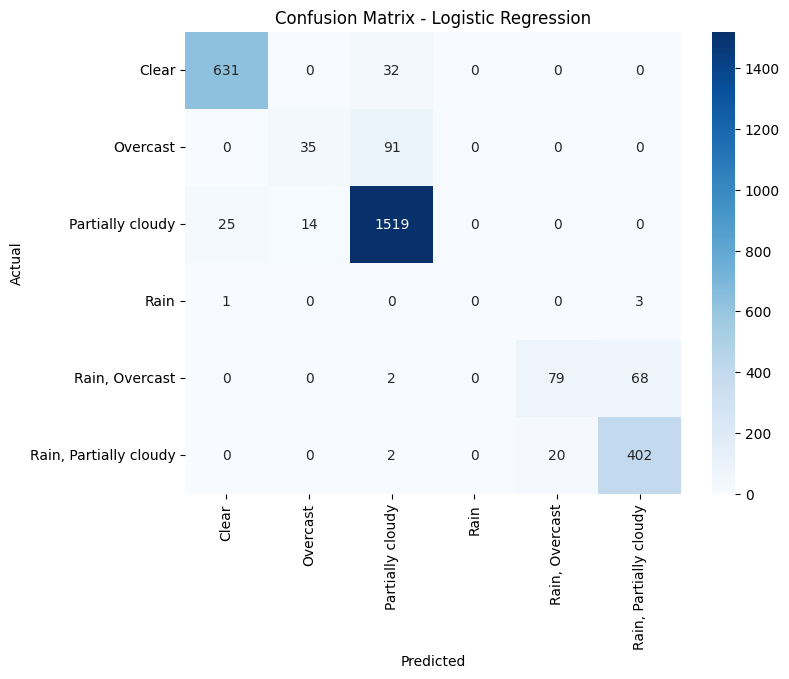

In [211]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [212]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [213]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [214]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9941
Overcast : 0.8668
Partially cloudy : 0.9760
Rain     : 0.7484
Rain, Overcast : 0.9335
Rain, Partially cloudy : 0.9902
Micro-avg : 0.9850


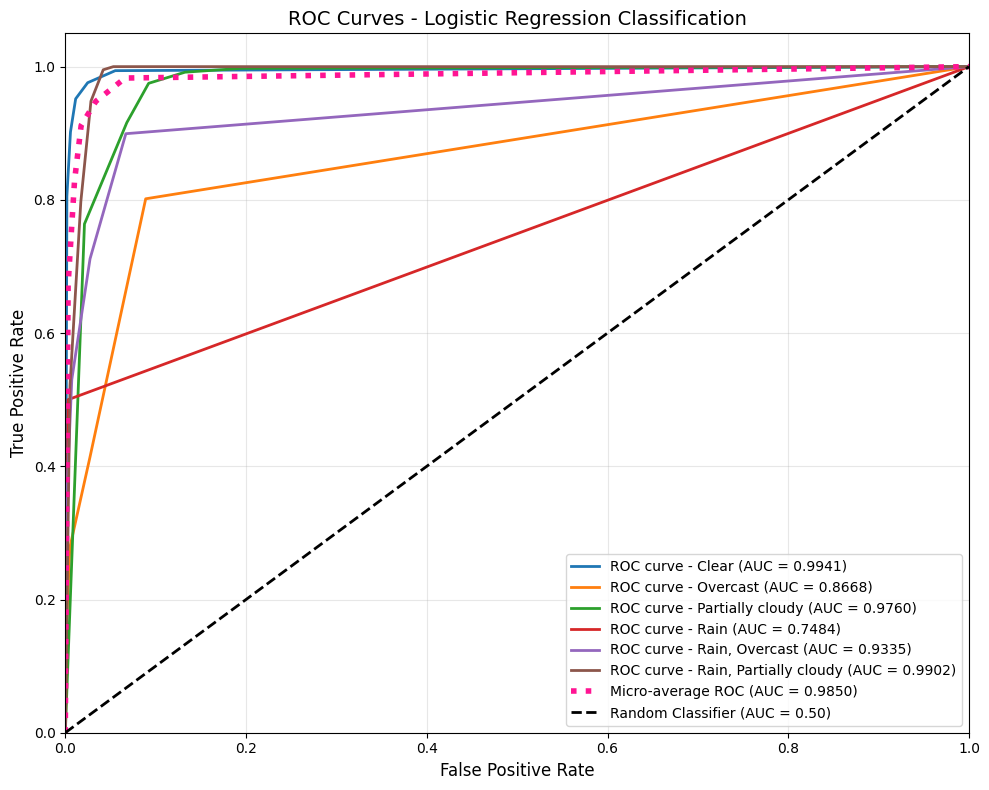

In [215]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [216]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9750
One-vs-One (Weighted)  : 0.9297
Micro-average          : 0.9850


In [217]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.866279 → 0.911765
   F1-Score: 0.851559 → 0.901681
   AUC (micro-avg): 0.975107 → 0.984950
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [218]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [219]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 13.6 s, sys: 6.02 s, total: 19.6 s
Wall time: 1h 20min 11s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 20, 'algorithm': 'auto'}
Best Cross-Validation Score: 0.9034605038490584


In [221]:
y_pred_grid = best_grid_model.predict(X_test)

In [222]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [223]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9090
Precision: 0.9009
Recall:    0.9090
F1-Score:  0.9021


In [224]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.95      0.95       663
              Overcast       0.62      0.33      0.43       126
      Partially cloudy       0.93      0.97      0.95      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.76      0.58      0.66       149
Rain, Partially cloudy       0.86      0.93      0.90       424

              accuracy                           0.91      2924
             macro avg       0.69      0.63      0.65      2924
          weighted avg       0.90      0.91      0.90      2924



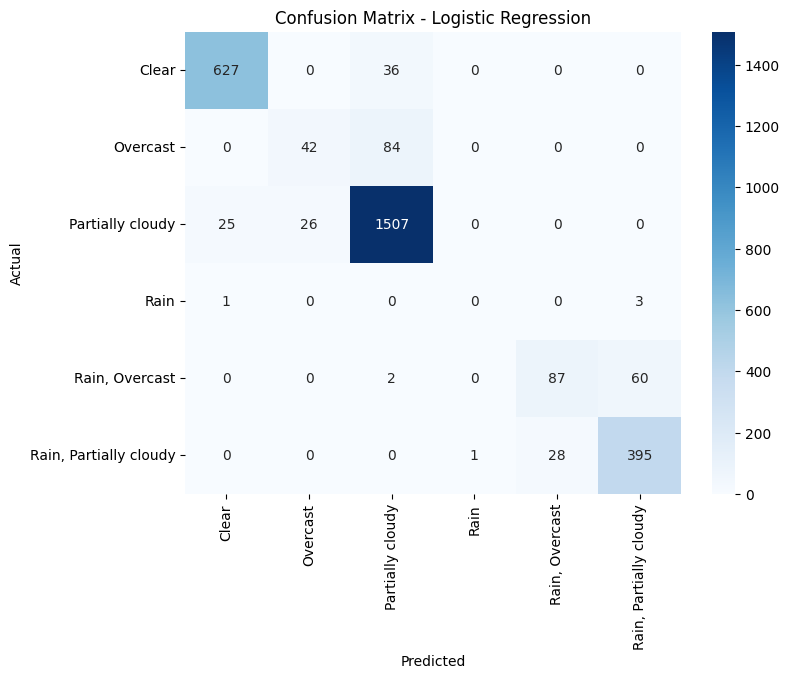

In [225]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [226]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [227]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [228]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9905
Overcast : 0.8228
Partially cloudy : 0.9727
Rain     : 0.6241
Rain, Overcast : 0.9039
Rain, Partially cloudy : 0.9866
Micro-avg : 0.9788


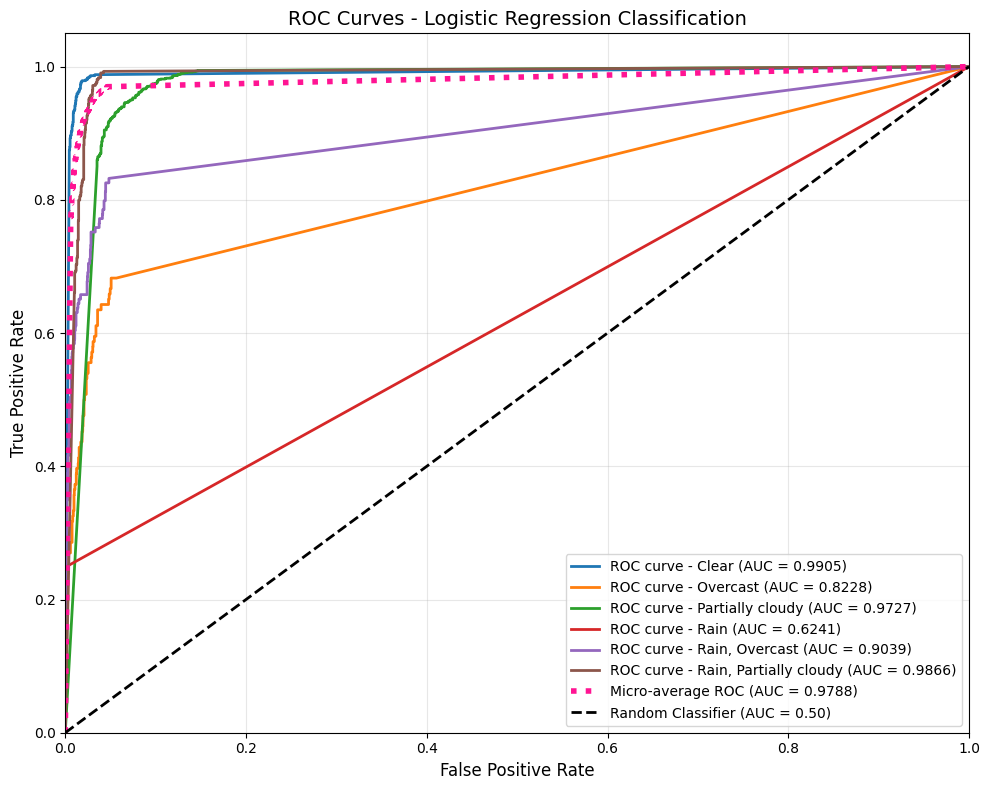

In [229]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [230]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9683
One-vs-One (Weighted)  : 0.9027
Micro-average          : 0.9788


In [231]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.874829 → 0.909029
   F1-Score: 0.865547 → 0.902095
   AUC (micro-avg): 0.977319 → 0.978770
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [232]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [233]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [234]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s


CPU times: user 132 ms, sys: 453 ms, total: 585 ms
Wall time: 1.07 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.1s finished


In [236]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [237]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9299
Precision: 0.9333
Recall:    0.9299
F1-Score:  0.9183


In [238]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.94      0.96       663
              Overcast       0.97      0.24      0.38       126
      Partially cloudy       0.92      0.99      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       1.00      0.62      0.76       149
Rain, Partially cloudy       0.87      1.00      0.93       424

              accuracy                           0.93      2924
             macro avg       0.79      0.63      0.67      2924
          weighted avg       0.93      0.93      0.92      2924



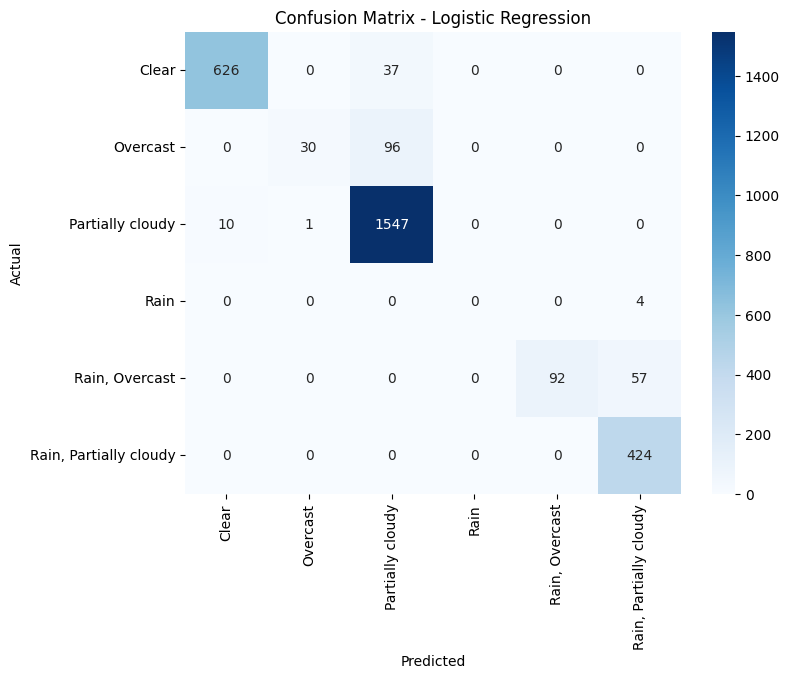

In [239]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [240]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.7s finished


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [241]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [242]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9967
Overcast : 0.9652
Partially cloudy : 0.9865
Rain     : 0.8636
Rain, Overcast : 0.9884
Rain, Partially cloudy : 0.9951
Micro-avg : 0.9919


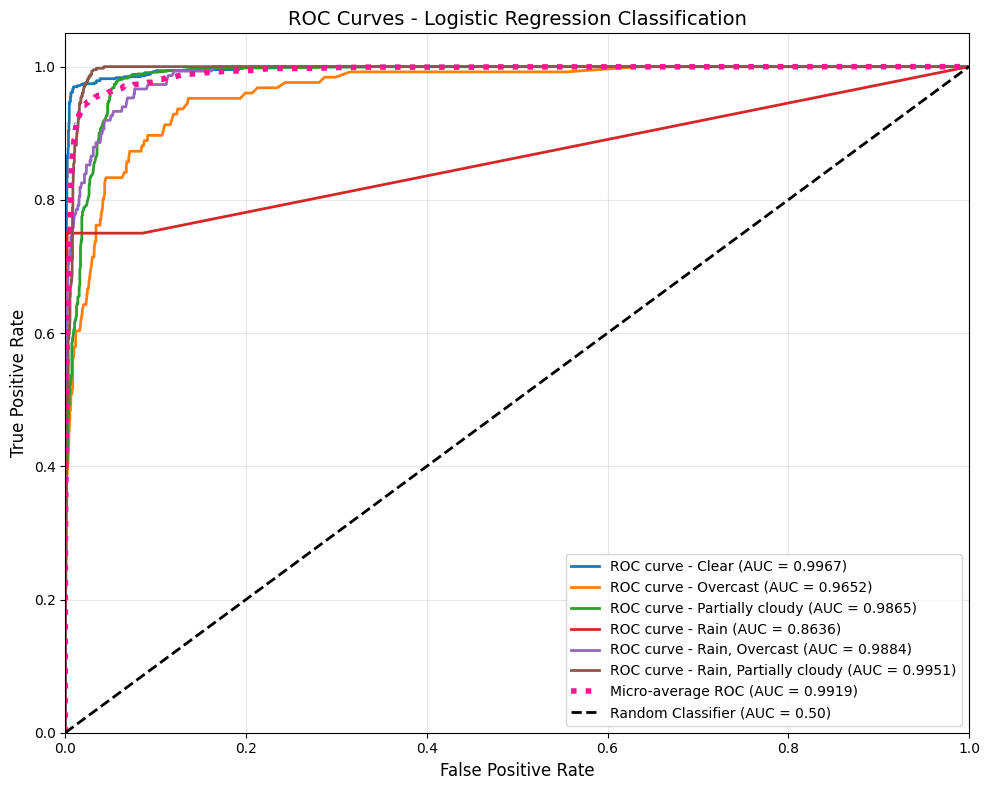

In [243]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [244]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9890
One-vs-One (Weighted)  : 0.9698
Micro-average          : 0.9919


In [245]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.918947 → 0.929891
   F1-Score: 0.903790 → 0.918325
   AUC (micro-avg): 0.991704 → 0.991938
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


### Robust Scaler

In [246]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [247]:
X_train

array([[ 1.00000000e+00,  3.33333333e-01,  1.00000000e+00, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01, -1.00000000e+00,  0.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01, -3.33333333e-01,  0.00000000e+00, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  2.50000000e-01,  1.00000000e+00, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]])

In [248]:
X_test

array([[-0.4       ,  0.        ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       ,  0.91666667,  0.        , ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.41666667,  1.        , ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.58333333,  0.        , ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       ,  0.66666667,  0.        , ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       , -0.5       ,  0.        , ..., -0.04159162,
         0.        , 33.75968992]])

#### Default Parameters

In [249]:
training_model = KNeighborsClassifier()
training_model

KNeighborsClassifier()

In [250]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 11.7 ms


KNeighborsClassifier()

In [251]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Overcast', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [252]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [253]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [254]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.8741
Precision: 0.8578
Recall:    0.8741
F1-Score:  0.8601


In [255]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.90      0.93       663
              Overcast       0.50      0.15      0.23       126
      Partially cloudy       0.90      0.97      0.93      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.51      0.37      0.43       149
Rain, Partially cloudy       0.79      0.88      0.83       424

              accuracy                           0.87      2924
             macro avg       0.61      0.55      0.56      2924
          weighted avg       0.86      0.87      0.86      2924



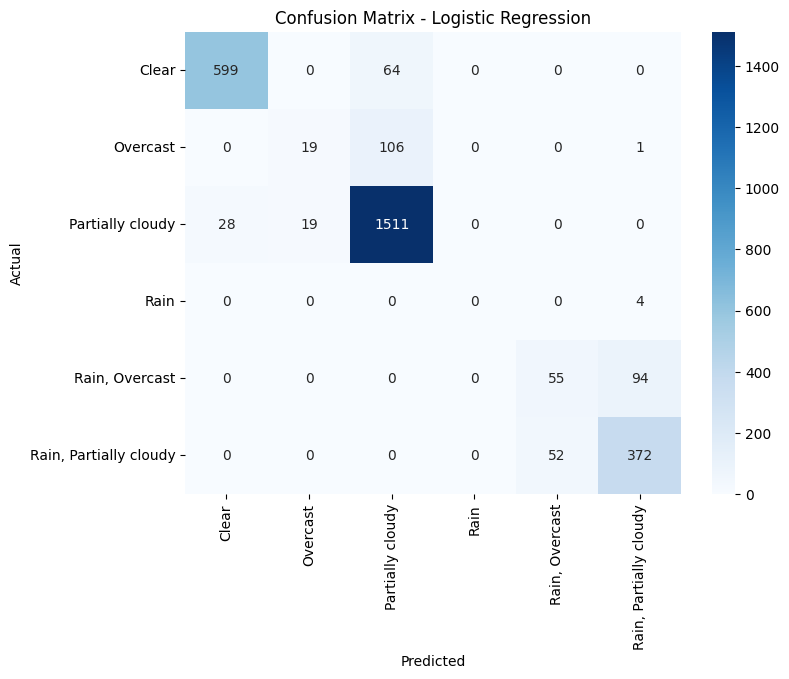

In [256]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [257]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [258]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [259]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9872
Overcast : 0.8077
Partially cloudy : 0.9639
Rain     : 0.7478
Rain, Overcast : 0.8878
Rain, Partially cloudy : 0.9731
Micro-avg : 0.9749


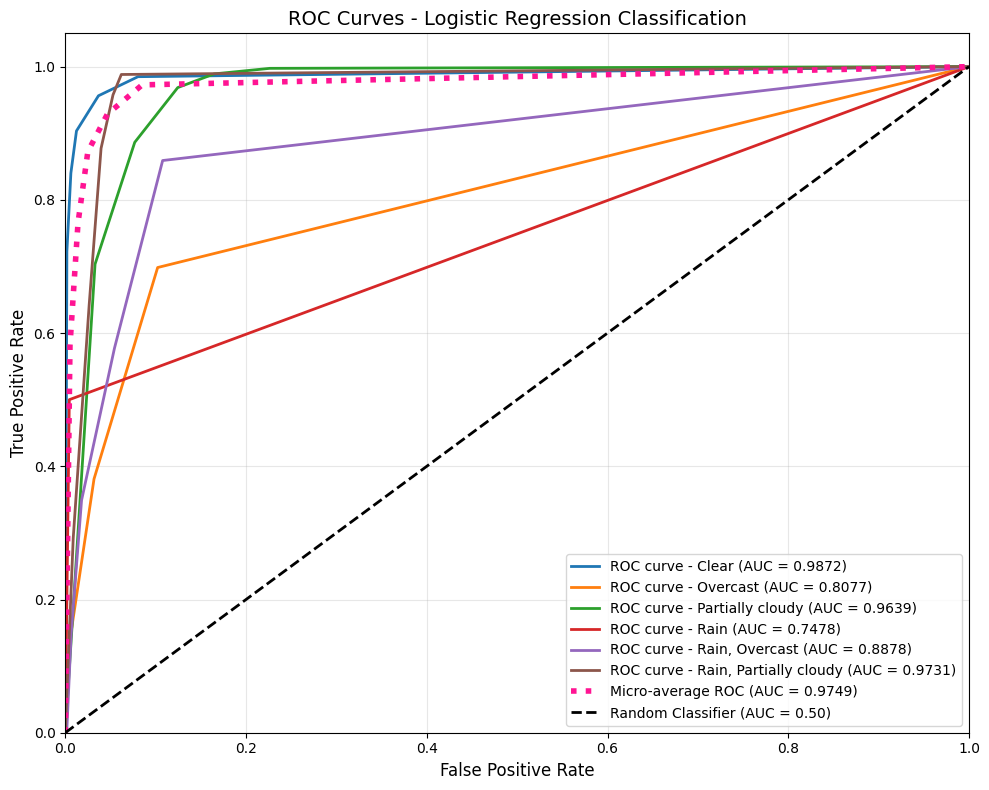

In [260]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [261]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9596
One-vs-One (Weighted)  : 0.9033
Micro-average          : 0.9749


In [262]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.835841 → 0.874145
   F1-Score: 0.818291 → 0.860130
   AUC (micro-avg): 0.966204 → 0.974875
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [263]:
grid_search = RandomizedSearchCV(
    KNeighborsClassifier(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [264]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: user 11.3 s, sys: 4.48 s, total: 15.8 s
Wall time: 1h 1s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 15, 21,
                                                        25],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [265]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'ball_tree'}
Best Cross-Validation Score: 0.8687503273099582


In [266]:
y_pred_grid = best_grid_model.predict(X_test)

In [267]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [268]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.8865
Precision: 0.8775
Recall:    0.8865
F1-Score:  0.8746


In [269]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.94      0.92      0.93       663
              Overcast       0.73      0.21      0.33       126
      Partially cloudy       0.91      0.97      0.94      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.58      0.44      0.50       149
Rain, Partially cloudy       0.81      0.89      0.85       424

              accuracy                           0.89      2924
             macro avg       0.66      0.57      0.59      2924
          weighted avg       0.88      0.89      0.87      2924



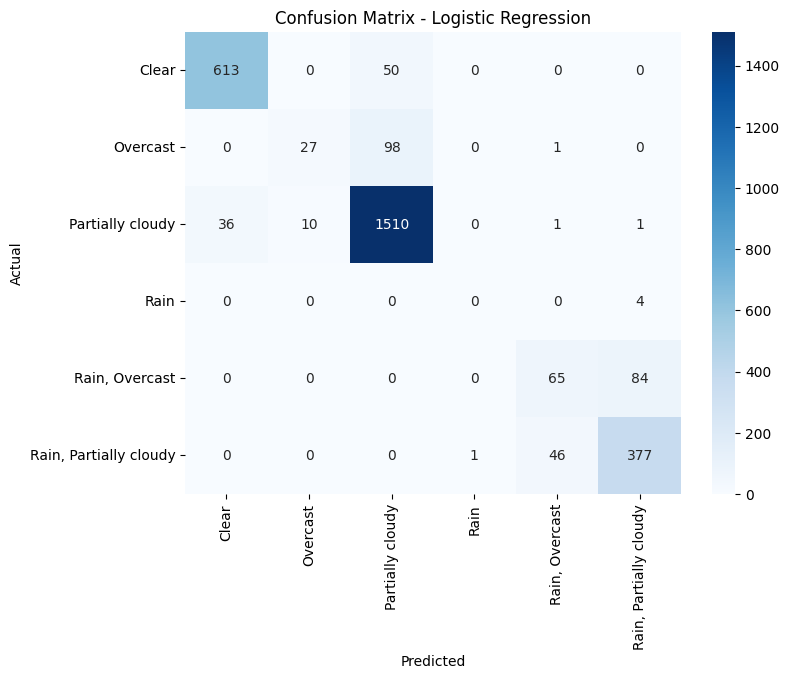

In [270]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [271]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [272]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [273]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9895
Overcast : 0.8599
Partially cloudy : 0.9708
Rain     : 0.7481
Rain, Overcast : 0.9055
Rain, Partially cloudy : 0.9813
Micro-avg : 0.9802


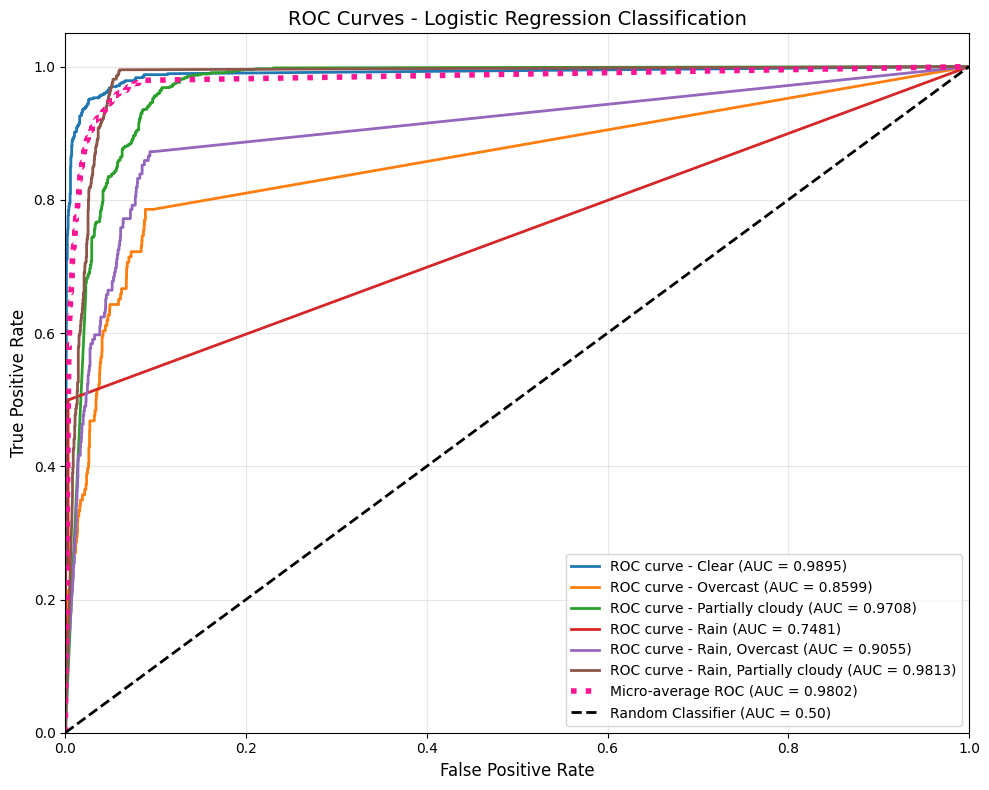

In [274]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [275]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9682
One-vs-One (Weighted)  : 0.9181
Micro-average          : 0.9802


In [276]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.850547 → 0.886457
   F1-Score: 0.830422 → 0.874648
   AUC (micro-avg): 0.976872 → 0.980193
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [277]:
base_model = KNeighborsClassifier()
base_model

KNeighborsClassifier()

In [278]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [279]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s


CPU times: user 153 ms, sys: 437 ms, total: 590 ms
Wall time: 1.12 s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


BaggingClassifier(bootstrap_features=True, estimator=KNeighborsClassifier(),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [280]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.2s finished


In [281]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [282]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8936
Precision: 0.8925
Recall:    0.8936
F1-Score:  0.8729


In [283]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.90      0.94       663
              Overcast       0.91      0.08      0.15       126
      Partially cloudy       0.90      0.99      0.94      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.72      0.38      0.50       149
Rain, Partially cloudy       0.81      0.95      0.87       424

              accuracy                           0.89      2924
             macro avg       0.72      0.55      0.57      2924
          weighted avg       0.89      0.89      0.87      2924



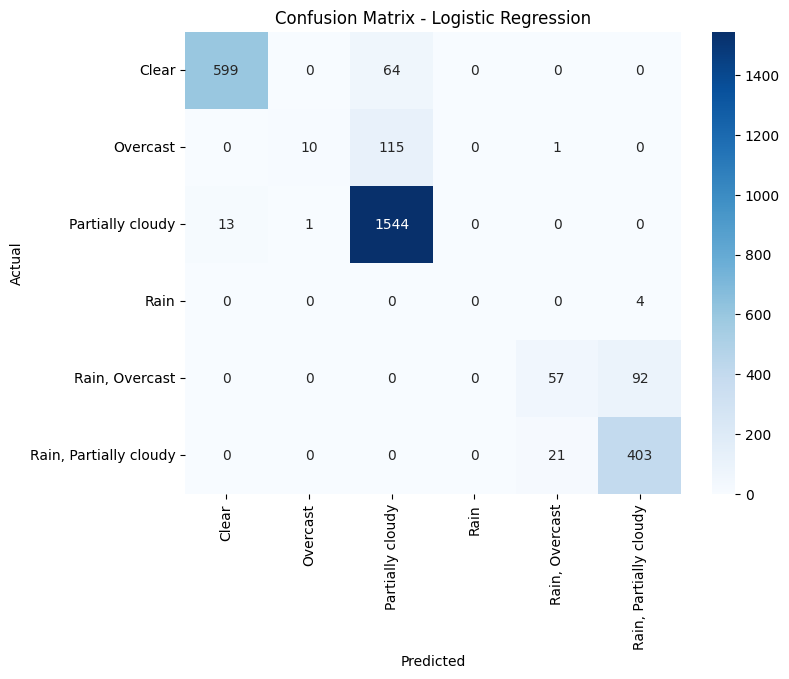

In [284]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [285]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.2s finished


In [286]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [287]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9954
Overcast : 0.9501
Partially cloudy : 0.9779
Rain     : 0.8593
Rain, Overcast : 0.9721
Rain, Partially cloudy : 0.9878
Micro-avg : 0.9886


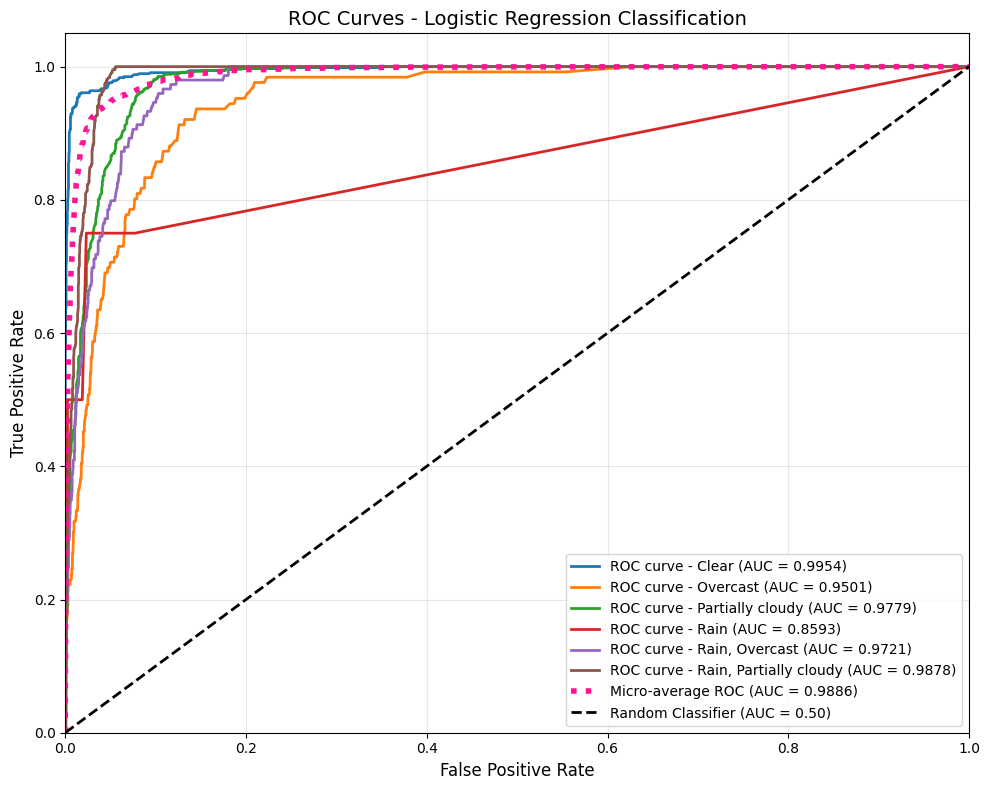

In [288]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [289]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9816
One-vs-One (Weighted)  : 0.9531
Micro-average          : 0.9886


In [290]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.892271 → 0.893639
   F1-Score: 0.867422 → 0.872935
   AUC (micro-avg): 0.989586 → 0.988574
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [291]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
      Model         Scaler     Target  Features Accuracy Precision   Recall F1-Score
   KNN Grid   MinMaxScaler Conditions        23 0.940834  0.938452 0.940834 0.936439
KNN Bagging   MinMaxScaler Conditions        23 0.943912  0.945909 0.943912 0.935225
        KNN   MinMaxScaler Conditions        23 0.936731  0.935192 0.936731 0.928818
KNN Bagging StandardScaler Conditions        23 0.929891  0.933256 0.929891 0.918325
   KNN Grid StandardScaler Conditions        23 0.909029  0.900869 0.909029 0.902095
        KNN StandardScaler Conditions        23 0.911765  0.904175 0.911765 0.901681
   KNN Grid   RobustScaler Conditions        23 0.886457  0.877505 0.886457 0.874648
KNN Bagging   RobustScaler Conditions        23 0.893639  0.892455 0.893639 0.872935
        KNN   RobustScaler Conditions        23 0.874145  0.857831 0.874145 0.860130

📈 Total models shown: 9
🏆 Best F1-Score: 0.936439 (KNN Grid + MinMaxScaler for Conditions)


# <center><font size="50" color="red">Thank You</font></center>